In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [0]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  5/24/20  5/25/20  5/26/20  5/27/20
0    Afghanistan  33.0000  65.0000        0  ...    10582    11173    11831    12456
1        Albania  41.1533  20.1683        0  ...      998     1004     1029     1050
2        Algeria  28.0339   1.6596        0  ...     8306     8503     8697     8857
3        Andorra  42.5063   1.5218        0  ...      762      763      763      763
4         Angola -11.2027  17.8739        0  ...       69       70       70       71

[5 rows x 130 columns]

# Finding Realted Countries

In [0]:
#this function returns a country's time series from the day first case was reported
def getTimeSeriesFromDayofFirstRegisteredCase(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)  #getting the data from the day of first case reported

#this function returns a country's time series from the day first case was reported
def getTimeSeriesCountry(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return series

def getTimeSeriesTill10thMay(country,dataset):
  dataset1 = dataset.loc[:,:'5/10/20']
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)

def getCroppedSeriesLength(country,dataset):
  return len(getTimeSeriesFromDayofFirstRegisteredCase(country,dataset))


# takes a dictionary with 6 key value pairs, the value must be the list representing the trend. First key value pair is comapred against rest 5
def printTrends(countriesTrends,title):
  countries = list(countriesTrends.keys())
  print(countries[0],len(countriesTrends[countries[0]]))
  fig,axs = plt.subplots(1,5,figsize=(40,8))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  index = 1
  mainTrendLength = len(countriesTrends[countries[0]])
  for i in range (5):
      print(countries[index],len(countriesTrends[countries[index]]))
      data = countriesTrends[countries[index]]
      axs[i].plot(data[:mainTrendLength], label = countries[index])
      axs[i].plot(countriesTrends[countries[0]], label = countries[0])
      axs[i].set_title(countries[index])
      axs[i].legend(loc='upper left')
      index+=1
  for ax in axs.flat:
      ax.set(xlabel='Day', ylabel='Confirmed Cases')

  fig,axs = plt.subplots(figsize=(10,10))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  axs.plot(countriesTrends[countries[0]], label = countries[0])
  index = 1
  for i in range (5):
      data = countriesTrends[countries[index]]
      axs.plot(data[:mainTrendLength], label = countries[index])
      axs.set_title(countries[index])
      index+=1
  axs.legend(loc='upper left')
  axs.set(xlabel='Day', ylabel='Confirmed Cases')

def getTop5(values,rev = True):
  top5Countries = list(values.keys())[1:6]
  result = {}
  for x in top5Countries:
    if (x in values.keys()):
      result[x] = values[x]
  result = {k: v for k, v in sorted(result.items(),reverse = rev, key=lambda item: item[1])}
  return result


def getSeries(type,country,dataset):
  if type == 0:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)
  elif type == 1:
    return getTimeSeriesCountry(country,dataset)
  elif type == 2:
    return getTimeSeriesTill10thMay(country,dataset)
  else:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)


In [0]:
#0 = getTimeSeriesFromDayofFirstRegisteredCase
#1 = getTimeSeriesCountry
#2 = getTimeSeriesTill10thMay
TYPE1 = 2
TYPE2 = 2
#127 since the beginning of record and until 27th May
#92 since first case and until 27th May
#75 since first case until 10th May
PAKISTAN_SERIES_LENGTH = 75

## Comparing Countries w.r.t Correlation

In [0]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE1,"Pakistan",dataset)
correlations = {}
for country in countries:
  countrySeries = getSeries(TYPE1,country,dataset)
  length = len(countrySeries)
  # if (TYPE1 == 1):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 25000): #skipping countries with no cases, less than 25000 cases or with length less than pakistan
    continue
  data = np.array([[pakistanSeries[idx] for idx in range(rng)], [countrySeries[idx] for idx in range(rng)]])
  arr = np.corrcoef(data) #finind correlations
  nan_array = np.isnan(arr)
  if (not nan_array[0][1]):
    correlations[country] = list(arr)[0][1]
correlations = {k: v for k, v in sorted(correlations.items(),reverse = True, key=lambda item: item[1])} #sorting countires by correlation
print(correlations)

{'Pakistan': 1.0, 'Brazil': 0.9973183087147555, 'Sweden': 0.9918830915864273, 'Belgium': 0.9880408068136433, 'Spain': 0.9812714818928003, 'Italy': 0.979794704478697, 'Germany': 0.9783518038592292, 'France': 0.9661904281908088, 'United Kingdom': 0.9658478959836521, 'Canada': 0.9396329683421342, 'India': 0.9193087772122968, 'Russia': 0.902233470011448, 'US': 0.900122479138501, 'Iran': 0.8995009815697568, 'Switzerland': 0.7908363792550077, 'China': 0.547702477922894}


In [0]:
# getting only top 5 countries
relationValues = getTop5(correlations,True)
print(relationValues)

{'Brazil': 0.9973183087147555, 'Sweden': 0.9918830915864273, 'Belgium': 0.9880408068136433, 'Spain': 0.9812714818928003, 'Italy': 0.979794704478697}


Pakistan 75
Brazil 75
Sweden 101
Belgium 97
Spain 100
Italy 101


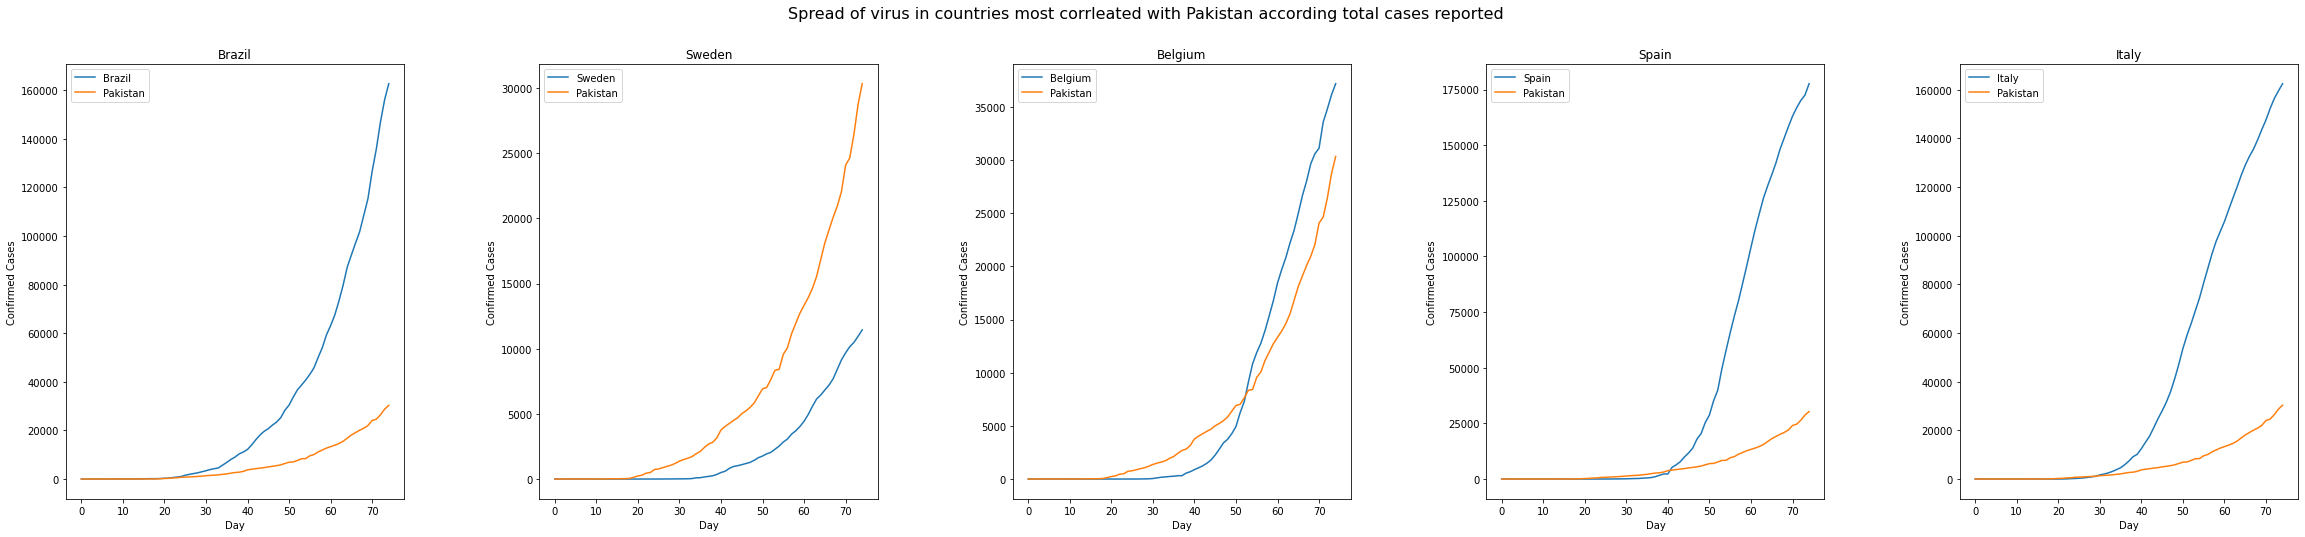

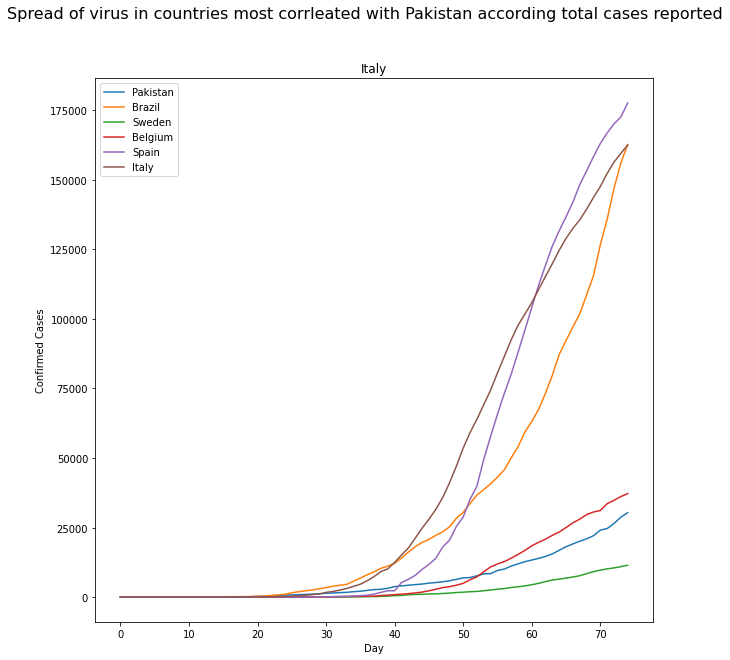

In [0]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE1,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE1,country,dataset)
printTrends(countryTrends,"Spread of virus in countries most corrleated with Pakistan according total cases reported")

## Comparing Countries w.r.t Difference between Cases per day

In [0]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE2,"Pakistan",dataset)
meanDiff = {}
for country in countries:
  countrySeries = getSeries(TYPE2,country,dataset)
  length = len(countrySeries)
  # if (TYPE2 != 2):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 25000): #skipping countries with no cases, less than 1000 cases or with length less than pakistan
    continue
  dat1 = np.array([pakistanSeries[idx] for idx in range(rng)])
  dat2 = np.array([countrySeries[idx] for idx in range(rng)])
  meanDiff[country] = np.mean(np.abs(dat1 - dat2))
meanDiff = {k: v for k, v in sorted(meanDiff.items(),reverse = False, key=lambda item: item[1])}
print(meanDiff)

{'Pakistan': 0.0, 'Belgium': 2429.7733333333335, 'Canada': 3893.4, 'Sweden': 4286.64, 'Russia': 4457.16, 'India': 5306.1466666666665, 'France': 7282.1466666666665, 'United Kingdom': 8871.573333333334, 'Switzerland': 9502.893333333333, 'Germany': 16217.573333333334, 'Brazil': 24645.306666666667, 'US': 29209.68, 'Spain': 33188.96, 'Iran': 34565.46666666667, 'Italy': 35584.64, 'China': 54916.46666666667}


In [0]:
#getting only top 5 countires
relationValues = getTop5(meanDiff,False)
print(relationValues)

{'Belgium': 2429.7733333333335, 'Canada': 3893.4, 'Sweden': 4286.64, 'Russia': 4457.16, 'India': 5306.1466666666665}


Pakistan 75
Belgium 97
Canada 106
Sweden 101
Russia 101
India 102


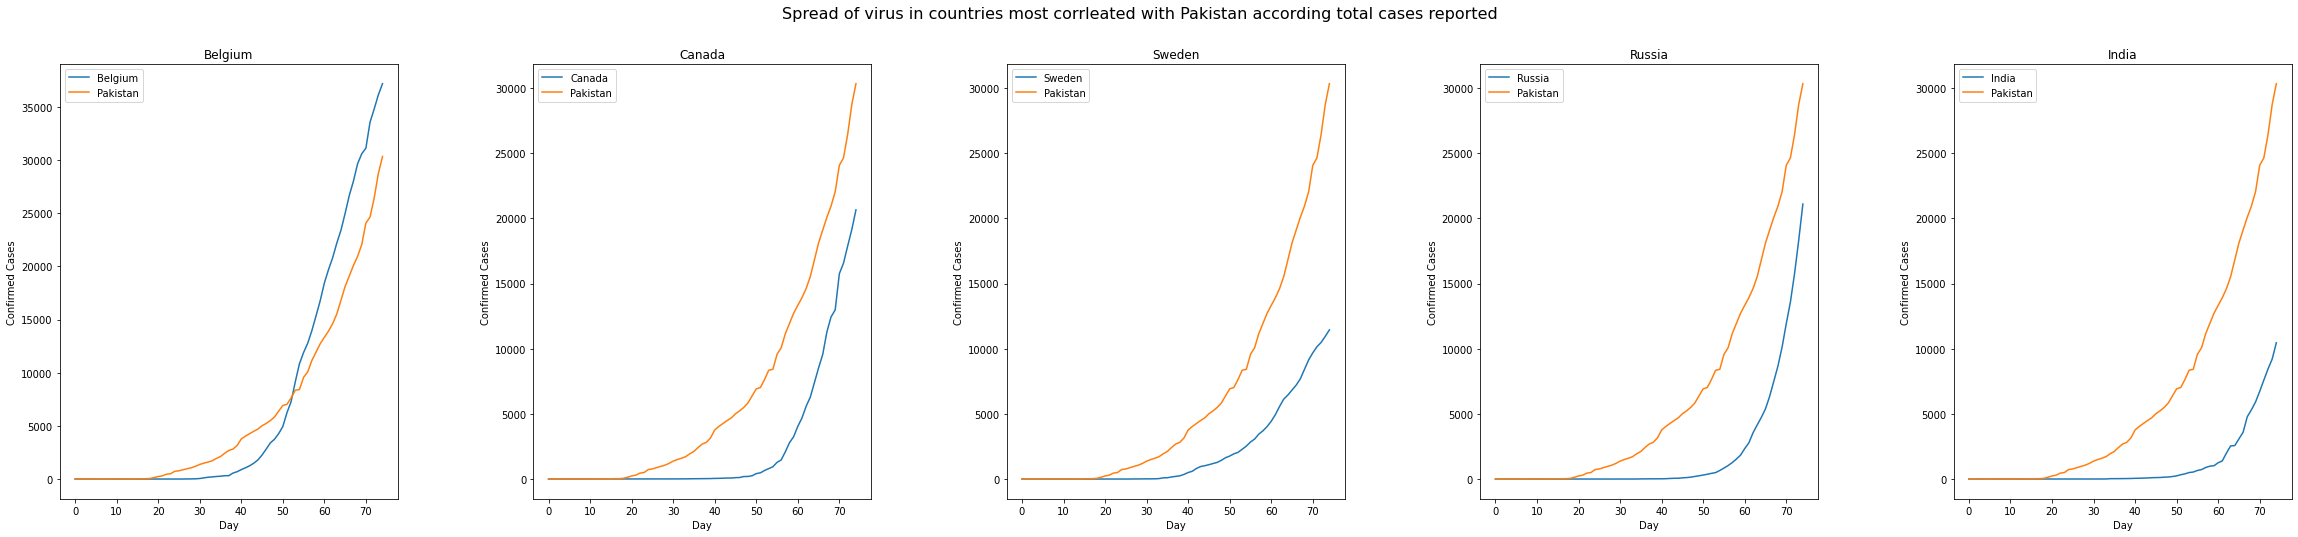

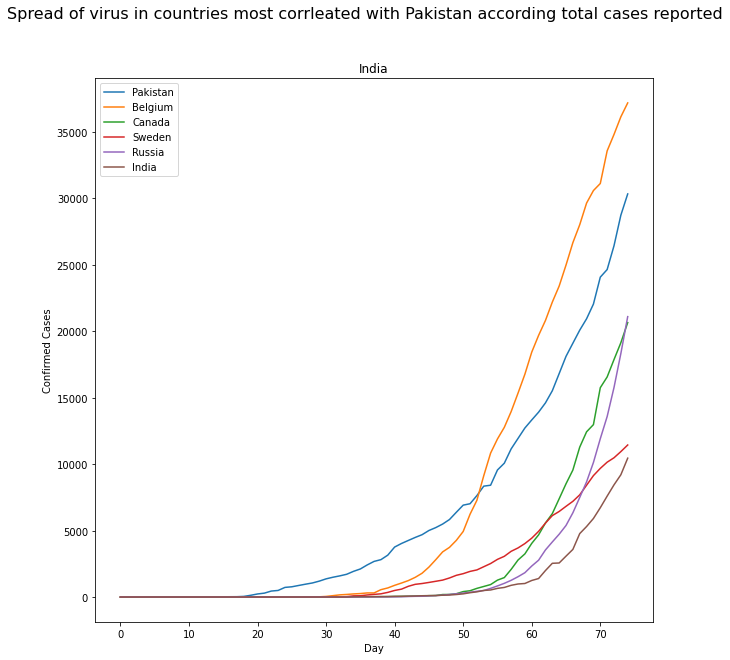

In [0]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Spread of virus in countries most corrleated with Pakistan according total cases reported')

## Final Selection based on both criteria

In [0]:
finalValues = {}
trend2 = {}
countries = list(meanDiff.keys())
for country in countries:
  trend2[country] = meanDiff[country]
maximumValue = (max(trend2.values()))
for country in countries:
  trend2[country] = abs(trend2[country] - maximumValue)
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
maximumValue2 = (max(trend2.values()))
for country in countries:
   trend2[country] = trend2[country]/maximumValue2
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
for country in countries:
  finalValues[country] = correlations[country] * 0.40 +  trend2[country] * 0.60
finalValues = {k: v for k, v in sorted(finalValues.items(),reverse = True, key=lambda item: item[1])}
print(finalValues)

{'Pakistan': 1.0, 'Belgium': 0.9686693853769754, 'Sweden': 0.9499187595439108, 'Canada': 0.9333151265002132, 'Russia': 0.9121958631577513, 'India': 0.9097502253979913, 'France': 0.9069137328091728, 'United Kingdom': 0.8894111453020626, 'Germany': 0.8141526285976779, 'Switzerland': 0.8125089353416399, 'Brazil': 0.7296604733486634, 'US': 0.6409132375949911, 'Spain': 0.6298964800574685, 'Italy': 0.6031313247539418, 'Iran': 0.5821490020917308, 'China': 0.21908099116915758}


In [0]:
#getting only top 5 countires
relationValues = getTop5(finalValues,True)
print(relationValues)

{'Belgium': 0.9686693853769754, 'Sweden': 0.9499187595439108, 'Canada': 0.9333151265002132, 'Russia': 0.9121958631577513, 'India': 0.9097502253979913}


Pakistan 75
Belgium 97
Sweden 101
Canada 106
Russia 101
India 102


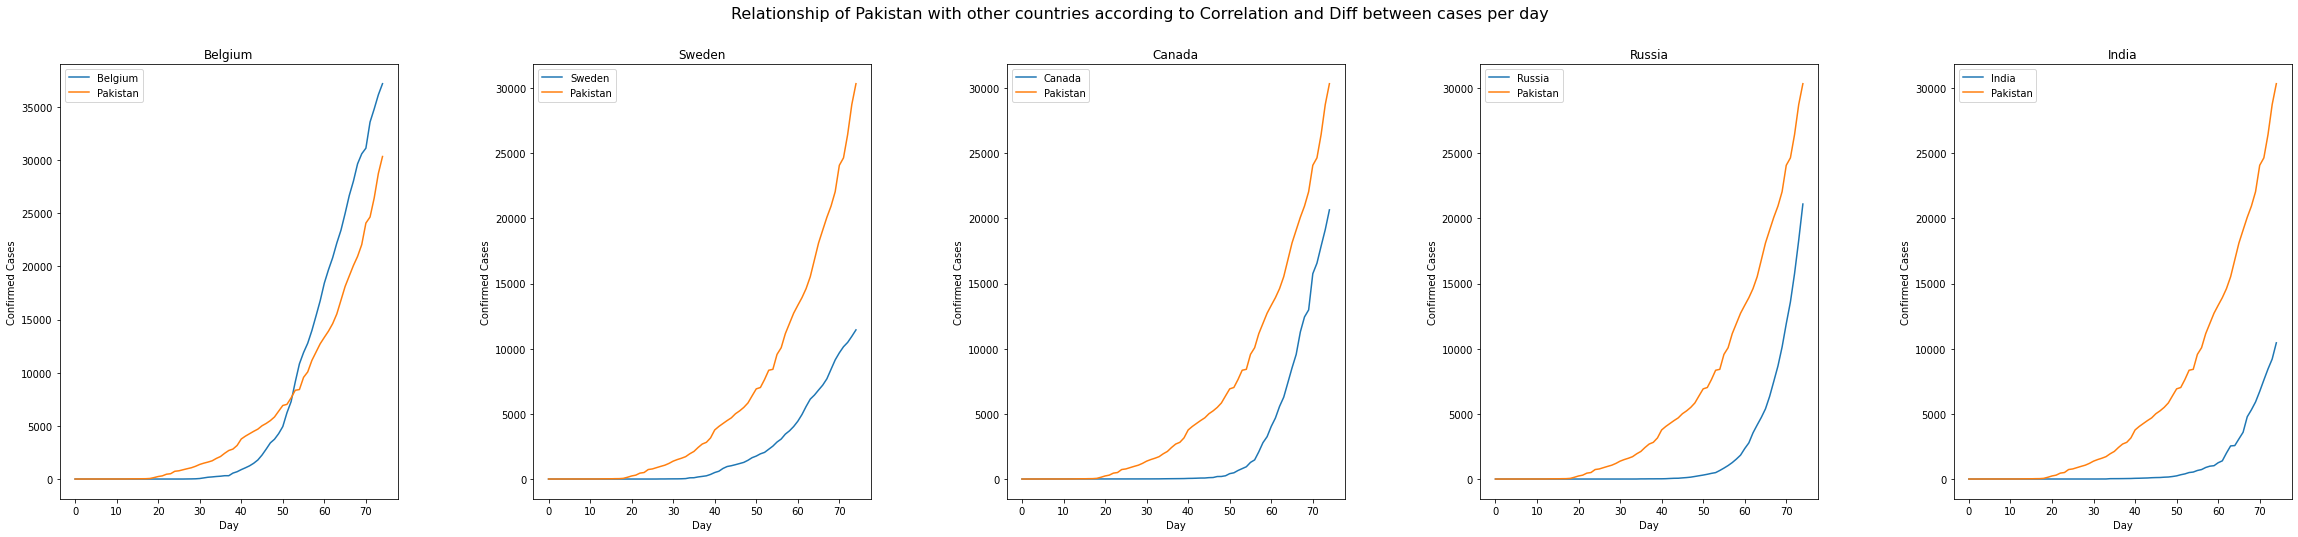

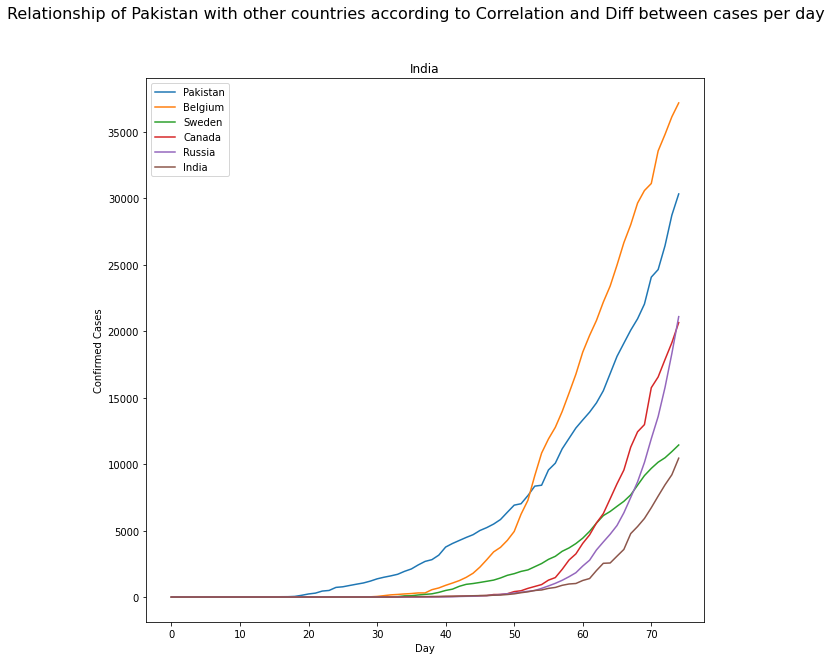

In [0]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Relationship of Pakistan with other countries according to Correlation and Diff between cases per day')

Final selection is dependent upon combining learnings from both approaches, we gave 40% weightage to correlation and 60% to difference approach, based on final score, top 5 countries are.
1. Belgium
2. Sweden
3. Canada
4. Russia
5. India


Please note that the correlations and difference were compared for first 75 days of a country's exposure to the virus, since Pakistan has 75 days between first case until 10th May.  
Including any more days into our preliminary analysis would be actually cheating as then we would actually be peaking into the future and finiding correlated countries that are bound to give more acurate predictions, as we have already seen their trend beyond 10th May.


# Forecasting

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [190]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  5/24/20  5/25/20  5/26/20  5/27/20
0    Afghanistan  33.0000  65.0000        0  ...    10582    11173    11831    12456
1        Albania  41.1533  20.1683        0  ...      998     1004     1029     1050
2        Algeria  28.0339   1.6596        0  ...     8306     8503     8697     8857
3        Andorra  42.5063   1.5218        0  ...      762      763      763      763
4         Angola -11.2027  17.8739        0  ...       69       70       70       71

[5 rows x 130 columns]

In [0]:
# Utility functions
def getTimeSeriesTillDate(country,dataset,date = '5/10/20',crop = True):
  dataset1 = dataset.loc[:,:date]
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = series.sum(axis = 0, skipna = True)
  if (crop):
    return np.trim_zeros(series)
  else:
    return series

def convertSeriesToActiveCases(series):
  newSeries = []
  newSeries.append(series[0])
  for i in range(len(series)-1):
    diff = series[i+1] - series[i] 
    newSeries.append(diff)
  return newSeries

def getDailyCaseSeries(country,dataset,date = '5/10/20',crop = True):
  series = getTimeSeriesTillDate(country,dataset,date,crop)
  return convertSeriesToActiveCases(series)


## Approach 1 (LSTM trained on non-stationary series)

The analysis below is based on top 5 countires picked via the observations above.  
- Each country is used to predict cases from 10th May to 27th May period of pakistan(training is done for first 74 days). Test RMSE are computed in this case for cases between 10th and 27th may, and predicted cases
-  Each country is also used to predict cases from 27th May to 27th June period of pakistan(training is done for first 92 days).  
- Each country data is trained on the same model, with same configurations
- The  daily cases series is kept non-stationary in this case, as LSTM have no pre-condition of stationary series

In [192]:
import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
register_matplotlib_converters()
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
pred_trend = {}
test_rmse = {}
train_rmse = {}
pak_rmse = {}
pred_trend_fut = {}

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def train_LSTM_model(model,epochs,train_data,test_data = None):
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_hist = []
  test_hist = []
  for i in range(epochs):
    train_loss = 0
    test_loss = 0
    for seq, labels in train_data:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        train_loss += single_loss.item()
        single_loss.backward()
        optimizer.step()

    train_loss = train_loss/len(train_data) 
    train_hist.append(train_loss)
    if test_data is not None:
      with torch.no_grad():
        for seq, labels in test_data:
          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
          y_pred = model(seq)
          single_loss = loss_function(y_pred, labels)
          test_loss += single_loss.item()
        test_loss = test_loss/len(test_data) 
        test_hist.append(test_loss)
      if i % 5 == 0:
        print(f'Epoch {i} train loss: {train_loss} test loss: {test_loss}')
    elif i % 5 == 0:
      print(f'Epoch {i} train loss: {train_loss}')
  if test_data is not None:
    print(f'Epoch {i} train loss: {train_loss} test loss: {test_loss}')
  else:
    print(f'Epoch {i} train loss: {train_loss}')
  return model.eval(),train_hist,test_hist

In [0]:
def create_sequences(series, window):
    sequences = []
    for i in range(len(series)-window):
        sample_seq = series[i:i+window]
        label = series[i+window:i+window+1]
        sequences.append((sample_seq ,label))
    return sequences

### Belgium


#### Prediction from 10th May to 27th May

In [407]:
#CONFIGURATIONS
COUNTRY = "Belgium"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

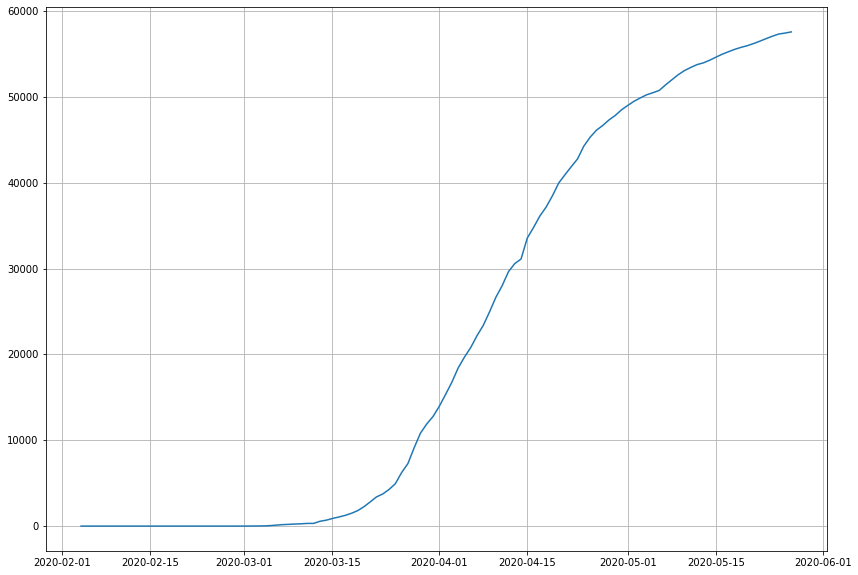

In [408]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

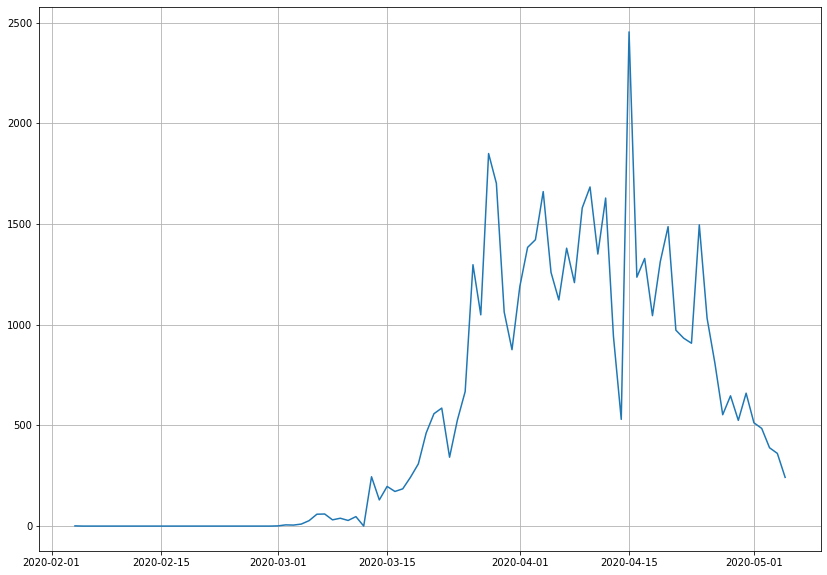

In [409]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

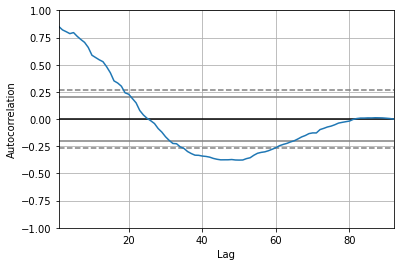

In [410]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Belgium, a suitable window size might be around 5, as the values are most correalted for that range

In [411]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [413]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 

In [414]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.01344448222617421 test loss: 0.06675419335563977
Epoch 5 train loss: 0.026085250766690087 test loss: 0.03027842682786286
Epoch 10 train loss: 0.01864520780915733 test loss: 0.026206923959155876
Epoch 15 train loss: 0.016247358838863267 test loss: 0.02938964869827032
Epoch 20 train loss: 0.014485254641567736 test loss: 0.03387923585250974
Epoch 25 train loss: 0.012669341944928648 test loss: 0.03764424558418492
Epoch 30 train loss: 0.011960622015456985 test loss: 0.05109996721148491
Epoch 35 train loss: 0.011760506715545814 test loss: 0.05536111160957565
Epoch 40 train loss: 0.011464866185899933 test loss: 0.059367179249723755
Epoch 45 train loss: 0.011201244803305598 test loss: 0.06406582975372051
Epoch 50 train loss: 0.010933193185220652 test loss: 0.06962548782272886
Epoch 55 train loss: 0.010651482173874781 test loss: 0.07624537818871129
Epoch 60 train loss: 0.010365399395419875 test loss: 0.08305048685694298
Epoch 65 train loss: 0.010049145949830874 test loss: 

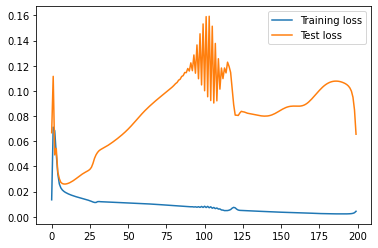

In [415]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [416]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.050294455140829086, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05014761537313461, 0.05033894255757332, 0.05151093378663063, 0.05212118849158287, 0.051552314311265945, 0.05674152821302414, 0.06587530672550201, 0.06862310320138931, 0.05564877390861511, 0.05613422766327858, 0.0706917941570282, 0.06554383039474487, 0.06076226383447647, 0.0915331095457077, 0.1441955268383026, 0.037085361778736115, 0.1339433491230011, 0.10221415013074875, 0.13767269253730774, 0.16264227032661438, 0.1867651343345642, 0.24564045667648315, 0.23083651065826416, 0.2334253489971161, 0.2714914381504059, 0.5082876682281494,

In [417]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1499 Actual 1313
Predicted 2528 Actual 1487
Predicted 1923 Actual 973
Predicted 1788 Actual 933
Predicted 1103 Actual 908
Predicted 427 Actual 1496
Predicted 1960 Actual 1032
Predicted 1768 Actual 809
Predicted 2249 Actual 553
Predicted 1638 Actual 647
Predicted 1492 Actual 525
Predicted 1608 Actual 660
Predicted 556 Actual 513
Predicted 1545 Actual 485
Predicted 2125 Actual 389
Predicted 1097 Actual 361
Predicted 1844 Actual 242
Train RMSE =  141.88163228127874
Test RMSE =  1047.8375539889496
RMSE Against Pakistan =  799.6546419322622


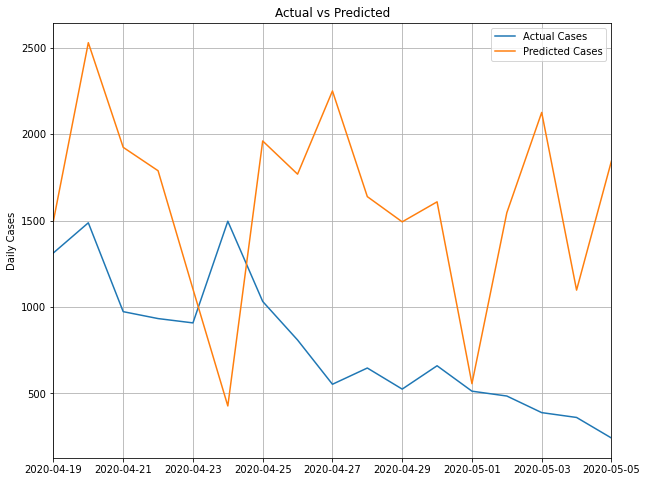

In [418]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

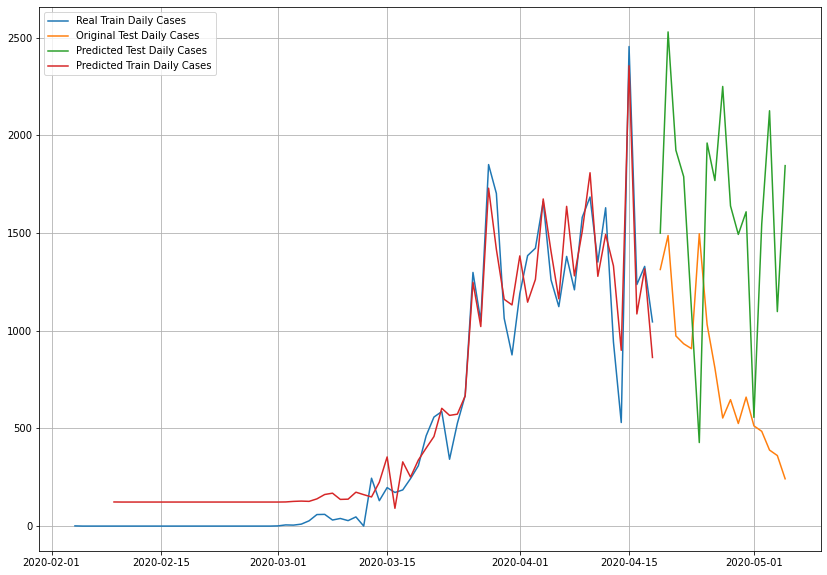

In [419]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

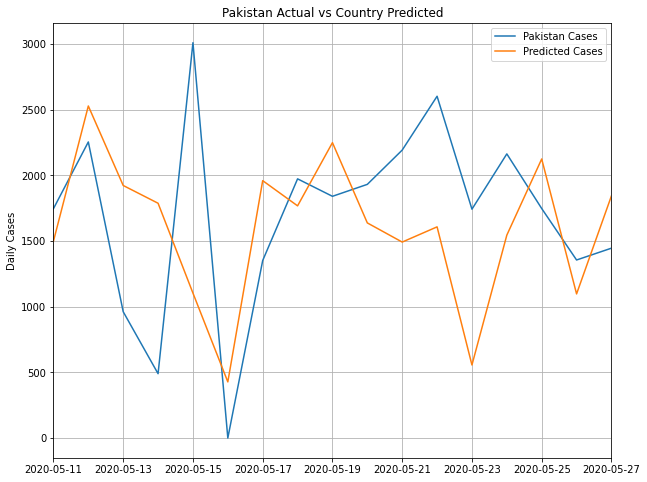

In [420]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [421]:
#CONFIGURATIONS
COUNTRY = "Belgium"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

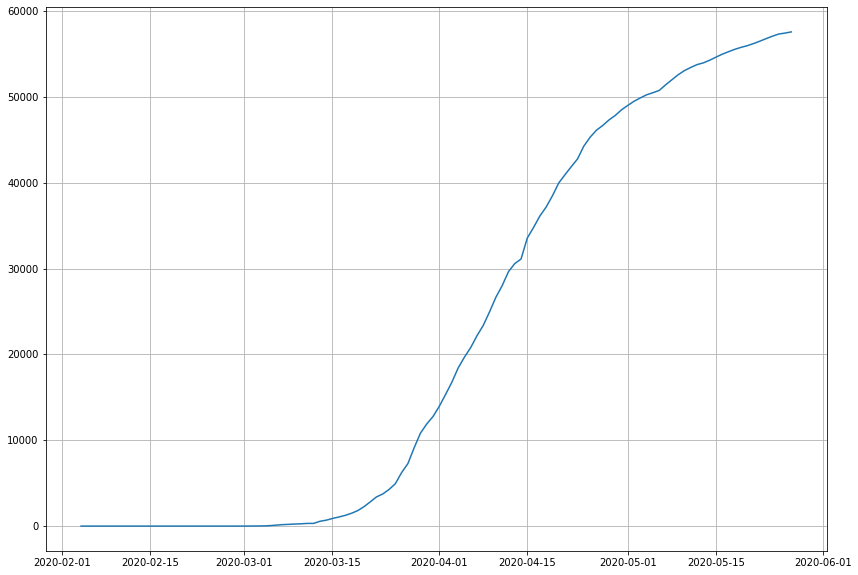

In [422]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

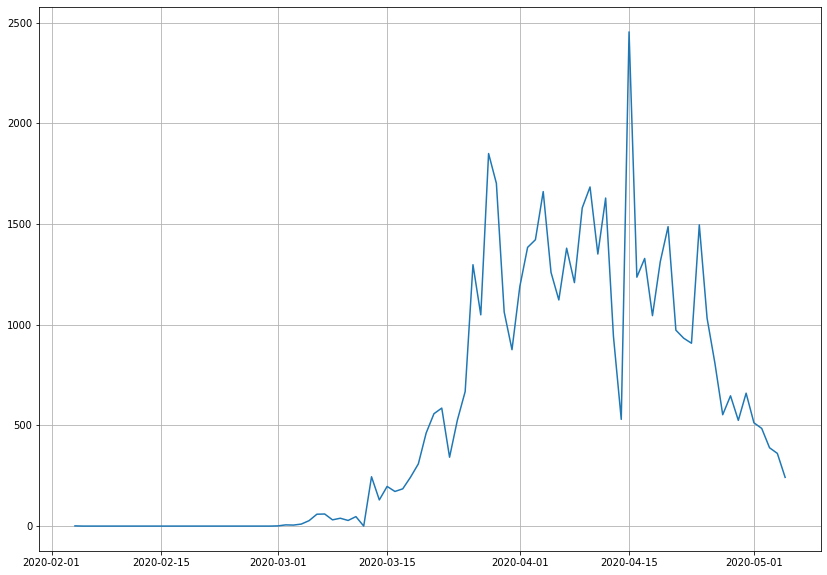

In [423]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

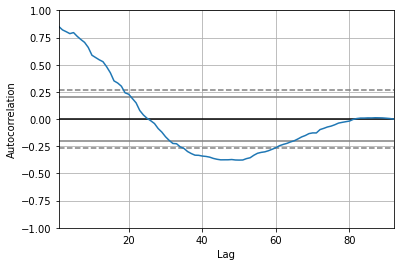

In [424]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Belgium, a suitable window size might be around 10, as the values are most correalted for that range

In [425]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [427]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.

In [428]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.017015802607054743
Epoch 5 train loss: 0.04624355464190791
Epoch 10 train loss: 0.022872638136850195
Epoch 15 train loss: 0.01853152800685798
Epoch 20 train loss: 0.01734945513262817
Epoch 25 train loss: 0.01677799853715378
Epoch 30 train loss: 0.01636774552715346
Epoch 35 train loss: 0.015721259464485875
Epoch 40 train loss: 0.015644785503677965
Epoch 45 train loss: 0.014080527349561006
Epoch 50 train loss: 0.013444240133071547
Epoch 55 train loss: 0.011921829574365456
Epoch 60 train loss: 0.011353352679693488
Epoch 65 train loss: 0.009908452765906427
Epoch 70 train loss: 0.009093356490997608
Epoch 75 train loss: 0.009316159247597065
Epoch 80 train loss: 0.009123055598388904
Epoch 85 train loss: 0.008353406982126483
Epoch 90 train loss: 0.007556162098114366
Epoch 95 train loss: 0.007299000244151229
Epoch 100 train loss: 0.005098261354286861
Epoch 105 train loss: 0.007222947227627594
Epoch 110 train loss: 0.003041919495455836
Epoch 115 train loss: 0.00150286740952

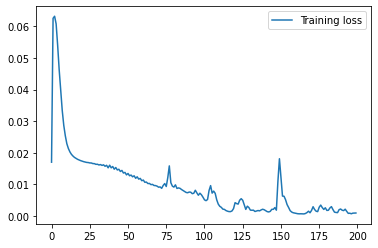

In [429]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [430]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.02868780493736267, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.02868911623954773, 0.028950318694114685, 0.030457645654678345, 0.03099861741065979, 0.03102681040763855, 0.036447927355766296, 0.04760921001434326, 0.050901949405670166, 0.0352921187877655, 0.029721364378929138, 0.03787139058113098, 0.0408136248588562, 0.03297249972820282, 0.08435307443141937, 0.11543990671634674, 0.05812042951583862, 0.07244694977998734, 0.0752449780702591, 0.11068081110715866, 0.13869844377040863, 0.17905840277671814, 0.229564368724823, 0.21008409559726715, 0.11240516602993011, 0.197640523314476, 0.4862814247608185, 0.4450766146183014, 0.710518479347229, 0.6235663890838623, 0.41112399101257324, 0.33034881949424744, 0

In [431]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
actual_predictions[actual_predictions < 0] = 0
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  97.14540109286271


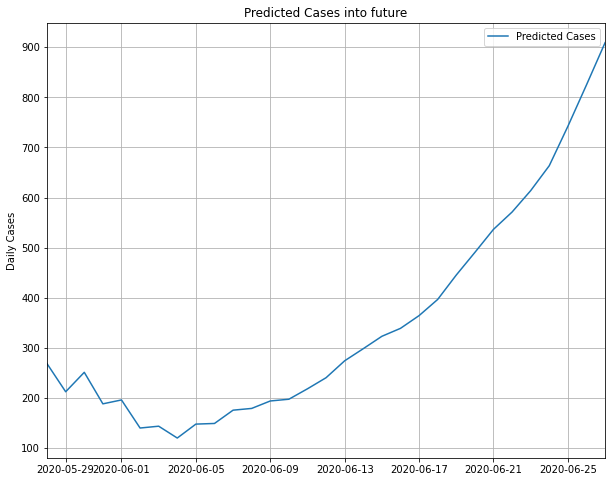

In [432]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

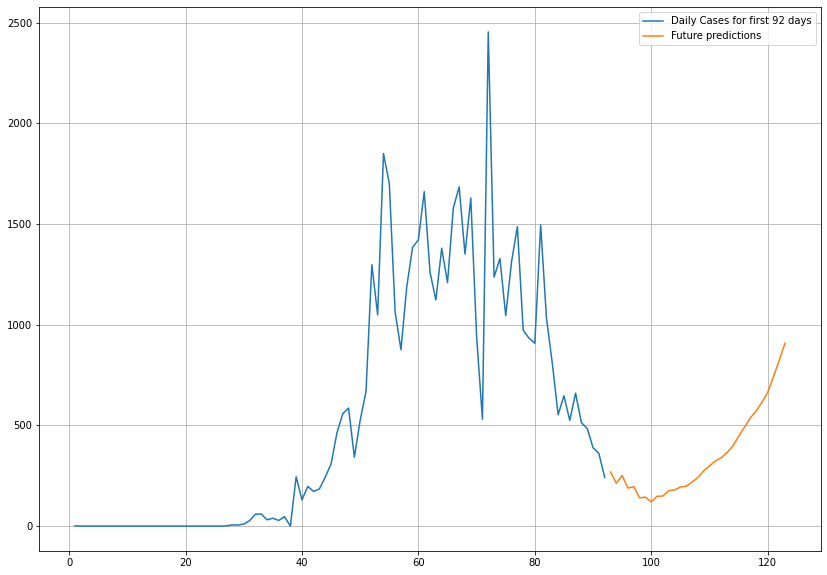

In [433]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Sweden


#### Predictions from 10th May to 27th May

In [434]:
#CONFIGURATIONS
COUNTRY = "Sweden"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

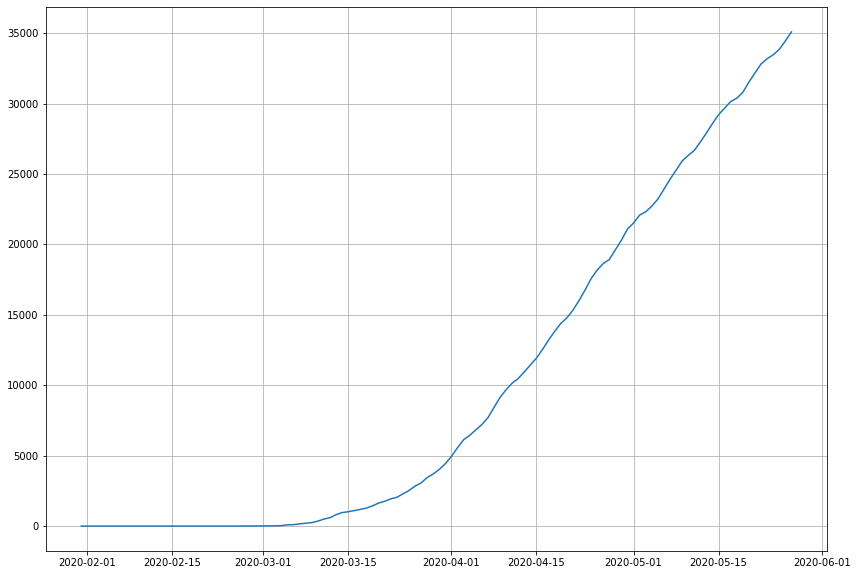

In [435]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

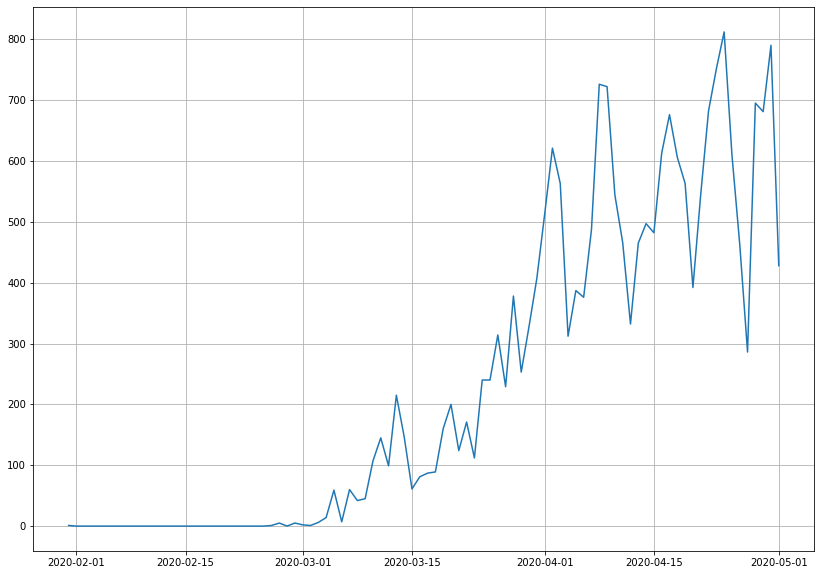

In [436]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

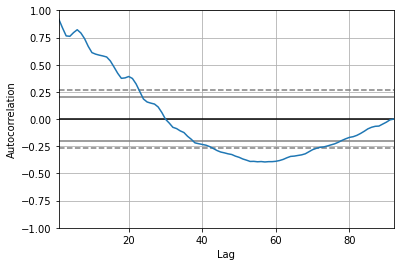

In [437]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Sweden, a suitable window size might be around 5, as the values are most correalted for that range

In [438]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [440]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0012, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 

In [441]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.011336276815863551 test loss: 0.0565115479597201
Epoch 5 train loss: 0.02396030440026412 test loss: 0.05253490700852126
Epoch 10 train loss: 0.012958447496297204 test loss: 0.047479424075087685
Epoch 15 train loss: 0.009493282375962484 test loss: 0.045134342062131814
Epoch 20 train loss: 0.008238217572719059 test loss: 0.04335135698784143
Epoch 25 train loss: 0.008050925270077057 test loss: 0.04016676626633853
Epoch 30 train loss: 0.007364662580100198 test loss: 0.030854545582163457
Epoch 35 train loss: 0.006524958218446792 test loss: 0.026336058013839647
Epoch 40 train loss: 0.006027105022001576 test loss: 0.026554529441758252
Epoch 45 train loss: 0.005714786845905451 test loss: 0.026988394500828388
Epoch 50 train loss: 0.005380703435555314 test loss: 0.026823211771746475
Epoch 55 train loss: 0.005002084585674117 test loss: 0.026311274220158037
Epoch 60 train loss: 0.004850383692448802 test loss: 0.02531691762639336
Epoch 65 train loss: 0.004708264685073768 test 

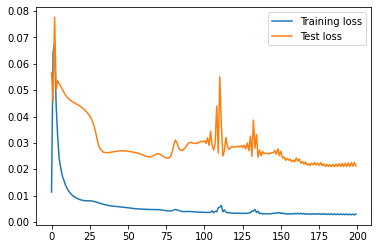

In [442]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [443]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.030252300202846527, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030259553343057632, 0.030780889093875885, 0.03329286724328995, 0.032405778765678406, 0.033196404576301575, 0.03371642529964447, 0.03184718266129494, 0.03425244241952896, 0.040301498025655746, 0.06853242218494415, 0.05951409041881561, 0.06841985136270523, 0.08374185860157013, 0.07502971589565277, 0.11805480718612671, 0.16862650215625763, 0.15808512270450592, 0.220621719956398, 0.23772573471069336, 0.1360873430967331, 0.13641609251499176, 0.13833528757095337, 0.1271696537733078, 0.17611642181873322, 0.240531504154

In [444]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 516 Actual 482
Predicted 496 Actual 613
Predicted 394 Actual 676
Predicted 306 Actual 606
Predicted 391 Actual 563
Predicted 499 Actual 392
Predicted 736 Actual 545
Predicted 1060 Actual 682
Predicted 1241 Actual 751
Predicted 1190 Actual 812
Predicted 872 Actual 610
Predicted 429 Actual 463
Predicted 545 Actual 286
Predicted 485 Actual 695
Predicted 494 Actual 681
Predicted 598 Actual 790
Predicted 487 Actual 428
Train RMSE =  39.93481609557572
Test RMSE =  247.88048391745642
RMSE Against Pakistan =  1282.7970488922933


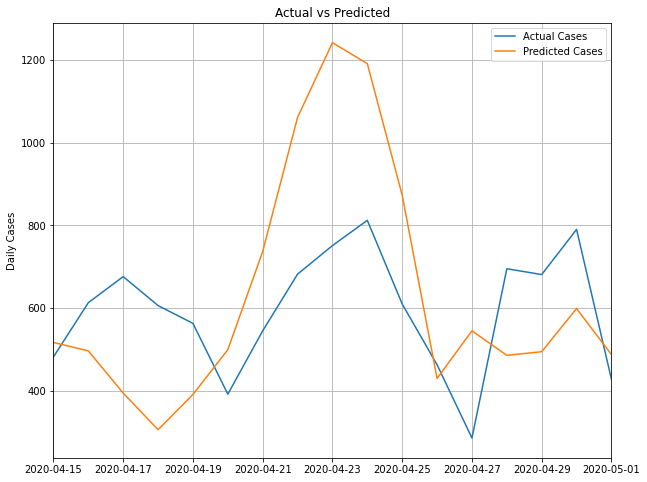

In [445]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

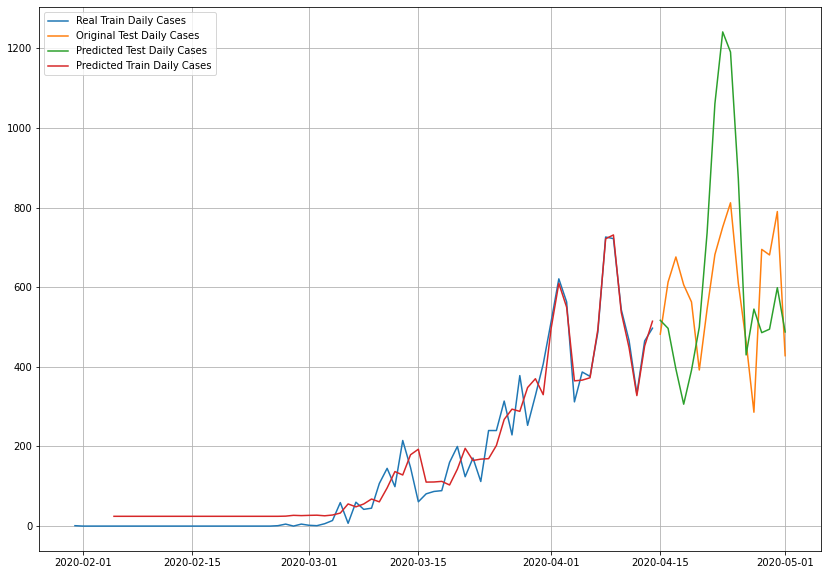

In [446]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

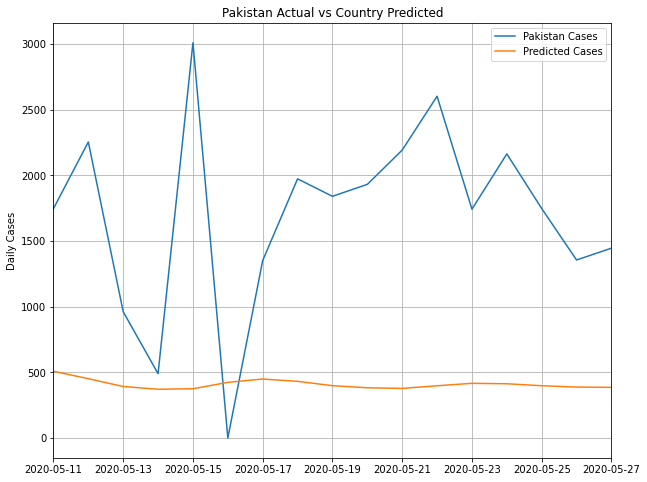

In [236]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [447]:
#CONFIGURATIONS
COUNTRY = "Sweden"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

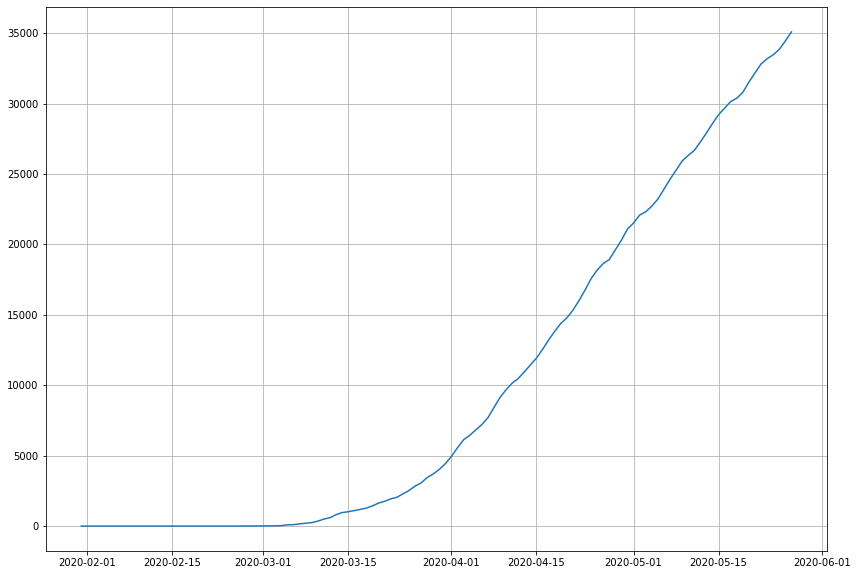

In [448]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

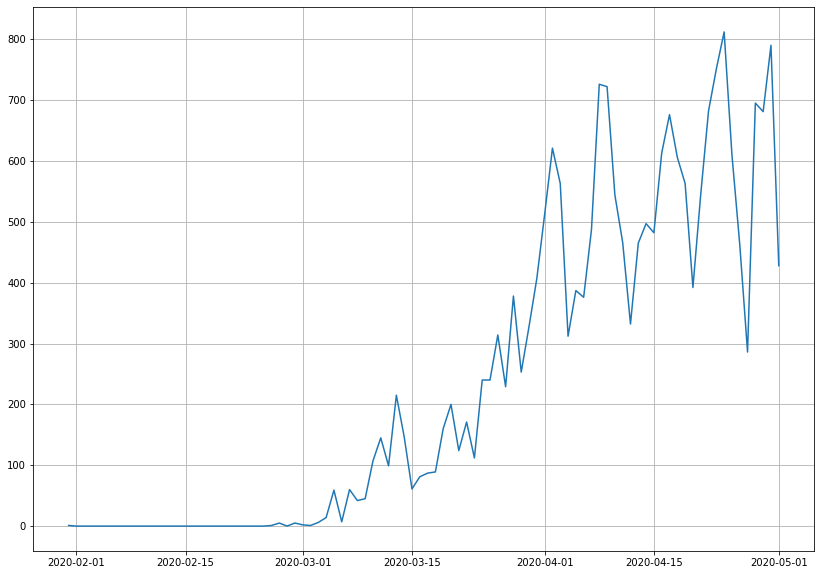

In [449]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

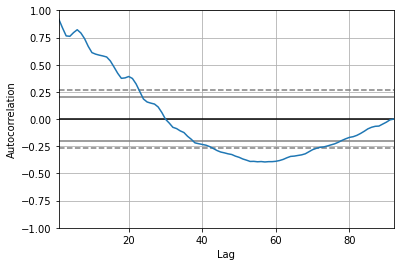

In [450]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Sweden, a suitable window size might be around 7, as the values are most correalted for that range

In [451]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [453]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [454]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.018636258533808105
Epoch 5 train loss: 0.03264909737610437
Epoch 10 train loss: 0.016080254347991072
Epoch 15 train loss: 0.013147809810382306
Epoch 20 train loss: 0.010737029465252674
Epoch 25 train loss: 0.010250351641374276
Epoch 30 train loss: 0.009569090186940531
Epoch 35 train loss: 0.009083028798092297
Epoch 40 train loss: 0.008816760265210988
Epoch 45 train loss: 0.008600962377932031
Epoch 50 train loss: 0.008447665667833375
Epoch 55 train loss: 0.00837797179459396
Epoch 60 train loss: 0.008381455502148034
Epoch 65 train loss: 0.008404751750468703
Epoch 70 train loss: 0.008355819330778882
Epoch 75 train loss: 0.008244499555386857
Epoch 80 train loss: 0.008117040627857426
Epoch 85 train loss: 0.007978116428219384
Epoch 90 train loss: 0.007807269539644574
Epoch 95 train loss: 0.007577944494367142
Epoch 100 train loss: 0.007303867845957544
Epoch 105 train loss: 0.007040517661459693
Epoch 110 train loss: 0.00679473436227474
Epoch 115 train loss: 0.006557681781

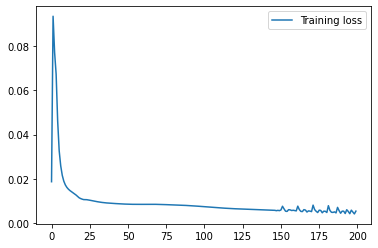

In [455]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [456]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.046576499938964844, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.046490803360939026, 0.04692866653203964, 0.04921472817659378, 0.049161024391651154, 0.04848664999008179, 0.048884421586990356, 0.04806032031774521, 0.049234844744205475, 0.055754199624061584, 0.08062991499900818, 0.08069902658462524, 0.07277213037014008, 0.08389545977115631, 0.08909198641777039, 0.11443613469600677, 0.16770118474960327, 0.164724662899971, 0.17686127126216888, 0.20963621139526367, 0.15312959253787994, 0.11709543317556381, 0.15232723951339722, 0.18835169076919556, 0.21328860521316528, 0.23412762582302094, 0.20395179092884064, 0.169696480035

In [457]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  52.04508935433092


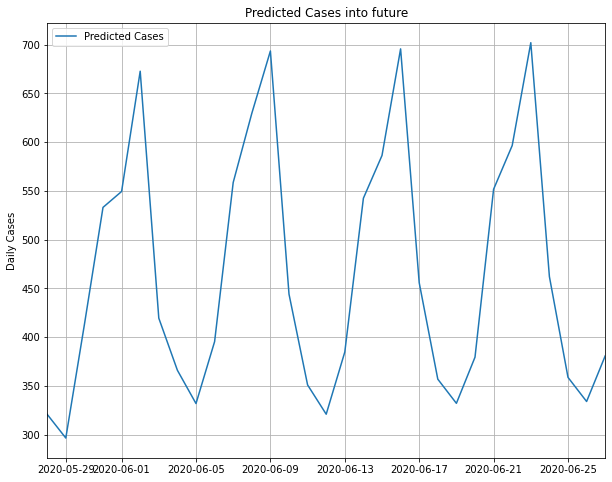

In [458]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

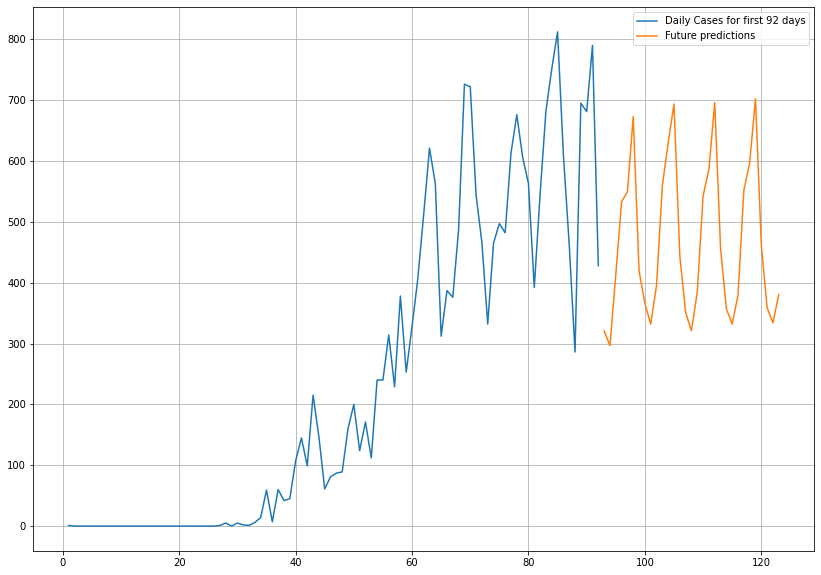

In [459]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### India


#### Predictions from 10th May to 27th May

In [460]:
#CONFIGURATIONS
COUNTRY = "India"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

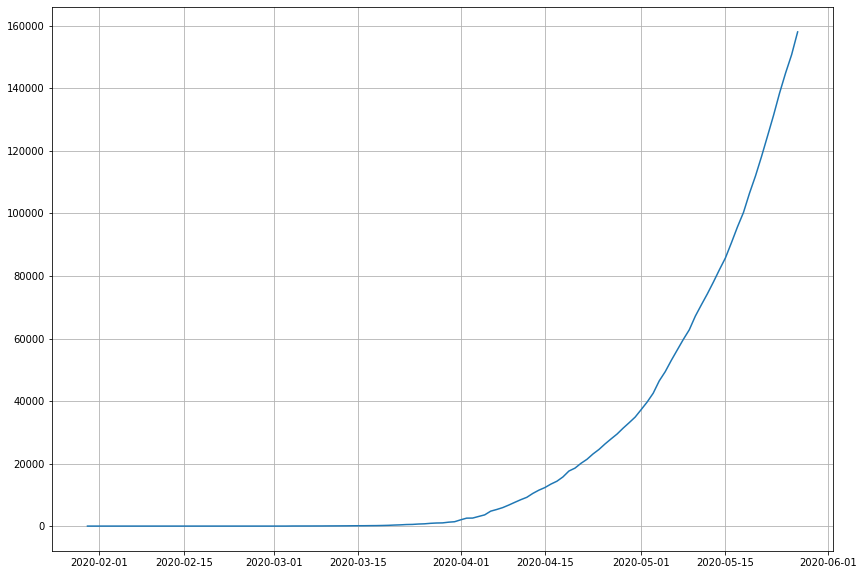

In [461]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

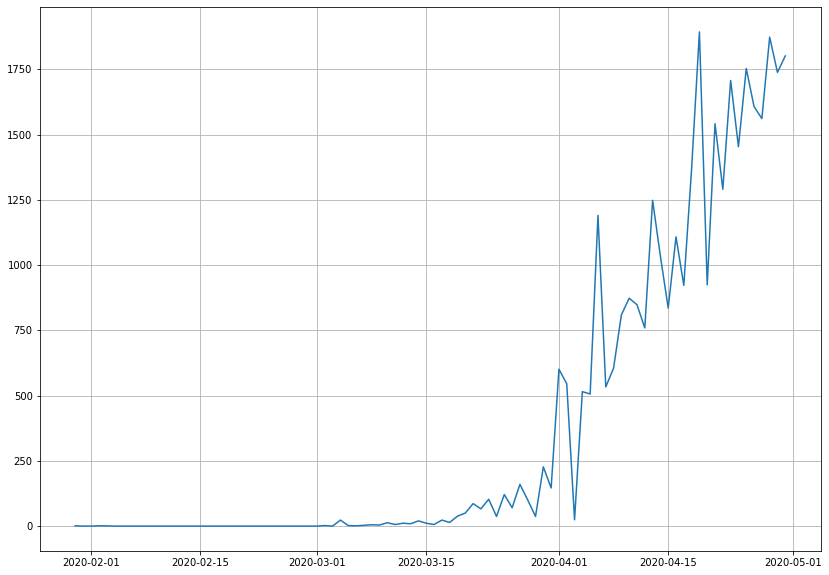

In [462]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

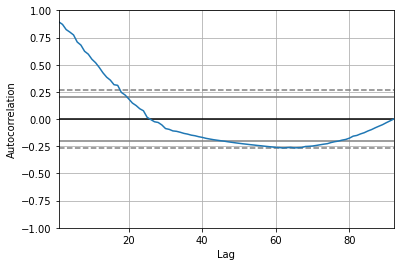

In [463]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for India, a suitable window size might be around 10, as the values are most correalted for that range

In [495]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [497]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0008, 0.0000, 0.0000, 0.0008, 0.0008, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0008, 0.0008, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0008, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0008, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.

In [503]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.02265033235280105 test loss: 0.2882238499820232
Epoch 5 train loss: 0.019076332880883107 test loss: 0.14369240382220597
Epoch 10 train loss: 0.014067000017569305 test loss: 0.062097369635012
Epoch 15 train loss: 0.016431336468335174 test loss: 0.04492447581178567
Epoch 20 train loss: 0.013995601424777333 test loss: 0.013087164155149367
Epoch 25 train loss: 0.011769365945399353 test loss: 0.05191023842344293
Epoch 30 train loss: 0.011843412112164194 test loss: 0.054649990849429744
Epoch 35 train loss: 0.01023257447757434 test loss: 0.1340838092379272
Epoch 40 train loss: 0.011562029176201683 test loss: 0.12405153289437294
Epoch 45 train loss: 0.00979693410551817 test loss: 0.23851171042770147
Epoch 50 train loss: 0.010601649872911815 test loss: 0.21074867737479508
Epoch 55 train loss: 0.009063325120929737 test loss: 0.3061482084915042
Epoch 60 train loss: 0.009754530253182736 test loss: 0.20639317854074762
Epoch 65 train loss: 0.007941475178041557 test loss: 0.1878

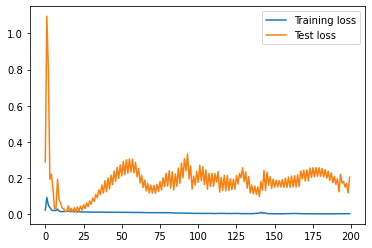

In [504]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [505]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.04064565151929855, 0.04058575630187988, 0.03966698795557022, 0.03943513333797455, 0.04011603444814682, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.040534235537052155, 0.04075410217046738, 0.041083551943302155, 0.04358499497175217, 0.04731015861034393, 0.047167107462882996, 0.0452549010515213, 0.036671943962574005, 0.02756144106388092, 0.03026440739631653, 0.045128241181373596, 0.04469403624534607, 0.04425853490829468, 0.04299607872962952, 0.04129929095506668, 0.04011603444814682, 0.04120336472988129, 0.039943620562553406, 0.037905216217041016, 0.046972401440143585, 0.0681151

In [506]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 805 Actual 1034
Predicted 465 Actual 835
Predicted 773 Actual 1108
Predicted 1267 Actual 922
Predicted 960 Actual 1370
Predicted 362 Actual 1892
Predicted 781 Actual 924
Predicted 1273 Actual 1541
Predicted 893 Actual 1290
Predicted 361 Actual 1707
Predicted 768 Actual 1453
Predicted 1302 Actual 1753
Predicted 867 Actual 1607
Predicted 357 Actual 1561
Predicted 764 Actual 1873
Predicted 1306 Actual 1738
Predicted 865 Actual 1800
Train RMSE =  48.43538561679372
Test RMSE =  764.9863286662456
RMSE Against Pakistan =  1145.4575653678462


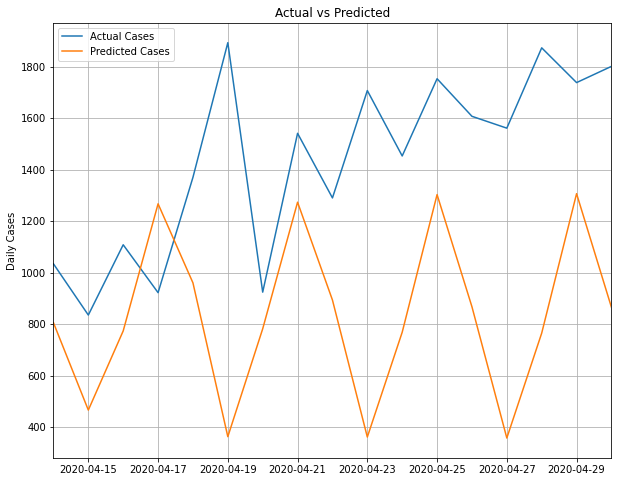

In [507]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

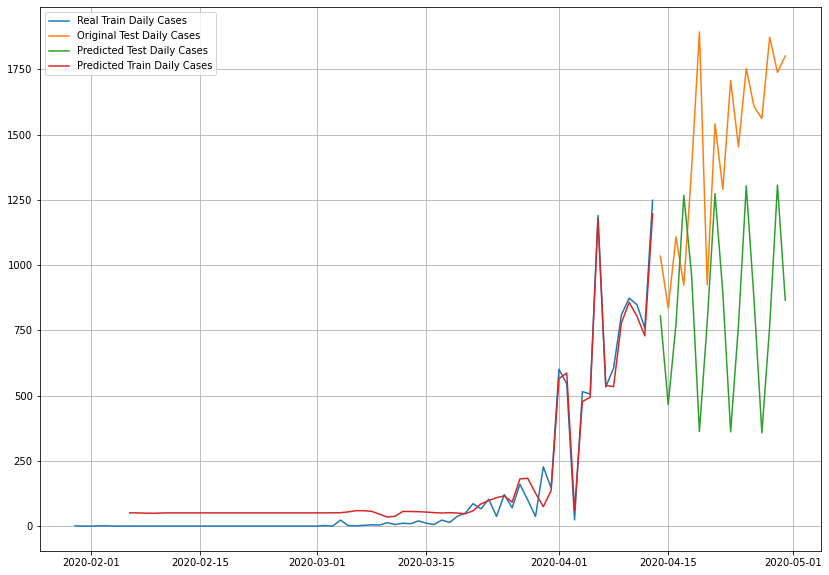

In [508]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

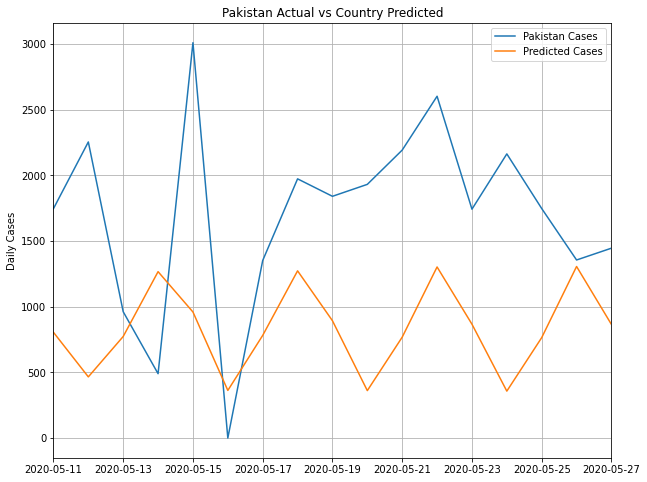

In [509]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [520]:
#CONFIGURATIONS
COUNTRY = "India"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

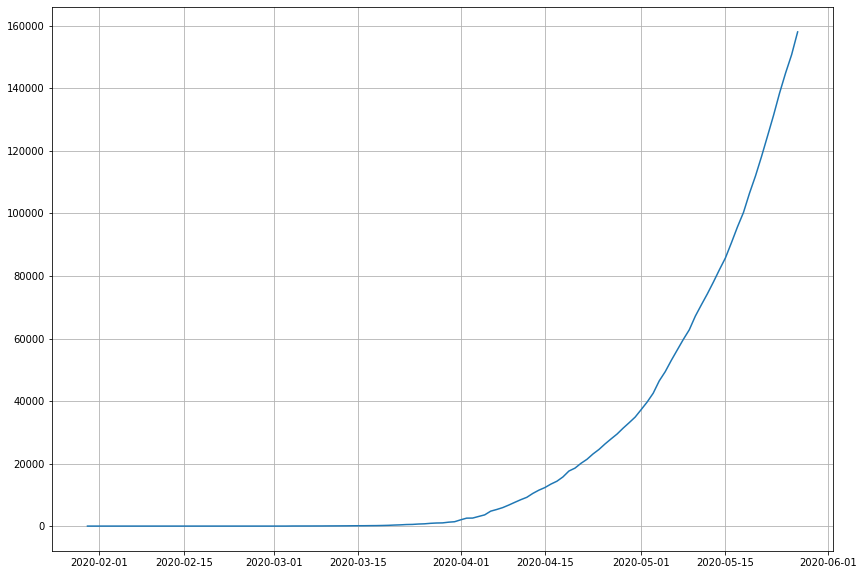

In [521]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

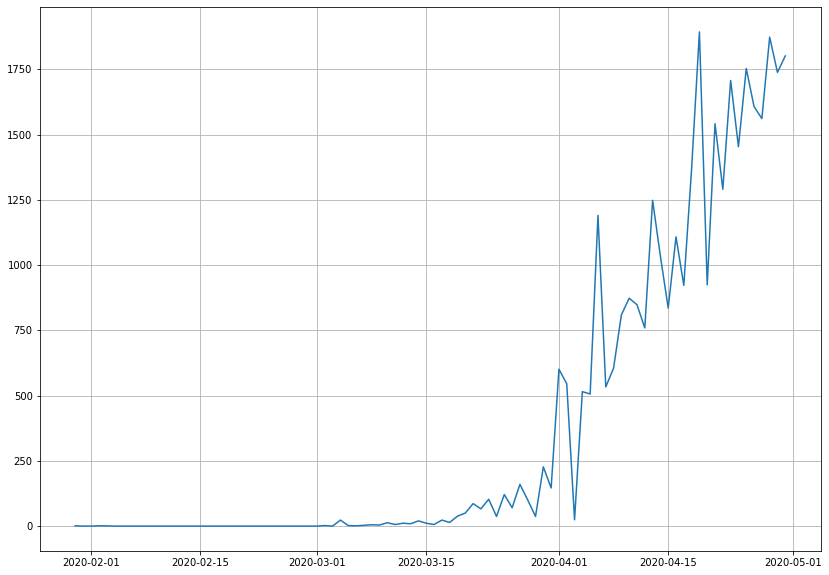

In [522]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

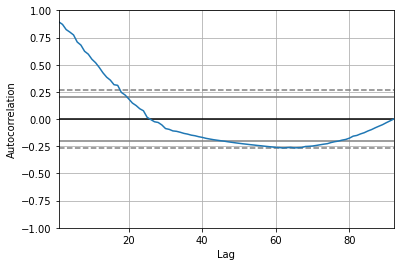

In [523]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for India, a suitable window size might be around 10, as the values are most correalted for that range

In [524]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [526]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0005, 0.0000, 0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 

In [527]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.011029258853687171
Epoch 5 train loss: 0.016741888386280417
Epoch 10 train loss: 0.009314903306488986
Epoch 15 train loss: 0.008434186021912708
Epoch 20 train loss: 0.008580853319694054
Epoch 25 train loss: 0.008610988324212485
Epoch 30 train loss: 0.008299384292532833
Epoch 35 train loss: 0.007947201849892125
Epoch 40 train loss: 0.007911579283966488
Epoch 45 train loss: 0.008117696036761783
Epoch 50 train loss: 0.008113182134629492
Epoch 55 train loss: 0.00694913608991672
Epoch 60 train loss: 0.00686137612382895
Epoch 65 train loss: 0.006395699371645045
Epoch 70 train loss: 0.00600358597232265
Epoch 75 train loss: 0.007549063396679132
Epoch 80 train loss: 0.0061552313988090055
Epoch 85 train loss: 0.005694192441946997
Epoch 90 train loss: 0.0054022847892373944
Epoch 95 train loss: 0.005129497888849833
Epoch 100 train loss: 0.005720102829784315
Epoch 105 train loss: 0.004959922855427297
Epoch 110 train loss: 0.005092331437689818
Epoch 115 train loss: 0.0066812070

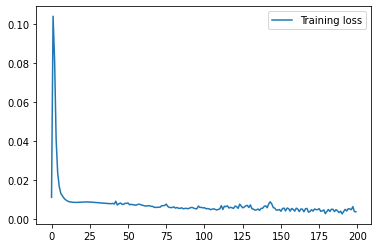

In [528]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [529]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.09171070903539658, 0.09154285490512848, 0.09163939952850342, 0.09176138788461685, 0.09178631007671356, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.0917595773935318, 0.09245690703392029, 0.09198513627052307, 0.09965042769908905, 0.0952584519982338, 0.09174187481403351, 0.09666084498167038, 0.10058041661977768, 0.09508046507835388, 0.09444401413202286, 0.09442513436079025, 0.09687985479831696, 0.09941871464252472, 0.10312478244304657, 0.10036838054656982, 0.09690365195274353, 0.10433440655469894, 0.104670450091362, 0.10814763605594635, 0.11471737921237946, 0.12987208366394043, 0.12991131842136383, 0.14779293537139893, 0.14244350790977478, 0.167617067694664, 0.160821914672851

In [530]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  177.6929834482068


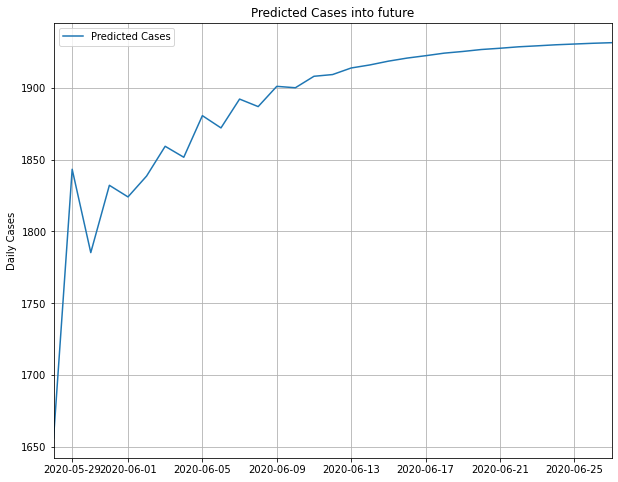

In [531]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

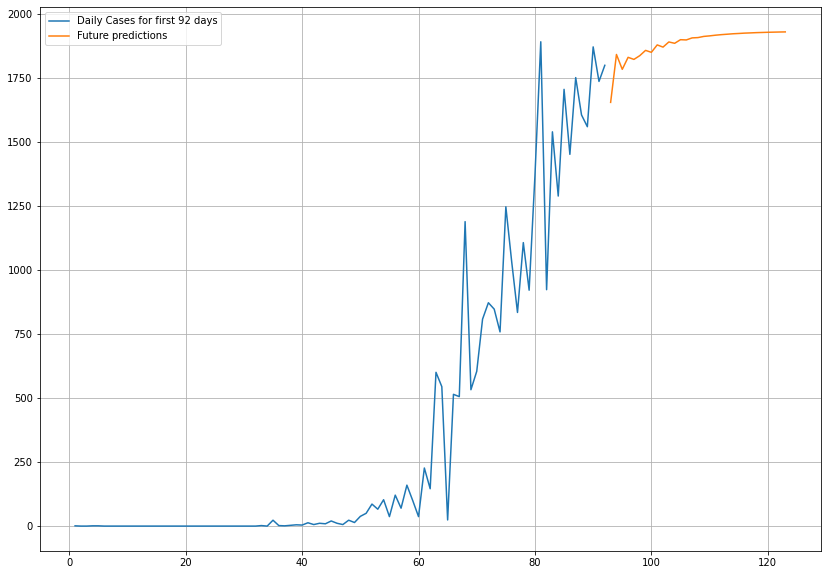

In [532]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Russia


#### Predictions from 10th May to 27th May

In [533]:
#CONFIGURATIONS
COUNTRY = "Russia"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

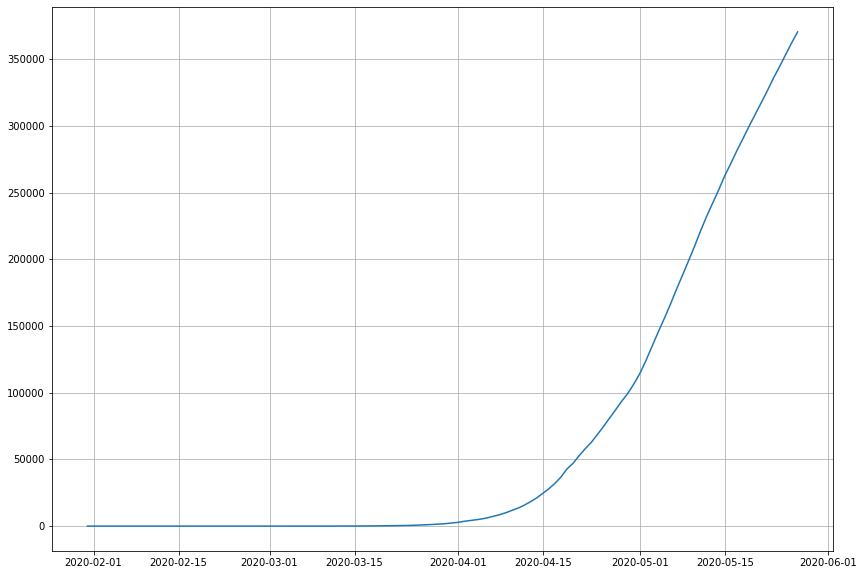

In [534]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

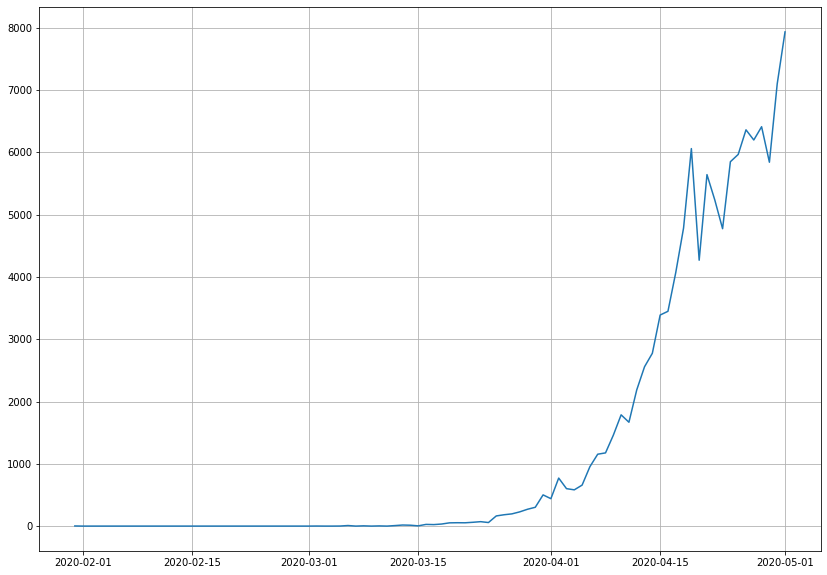

In [535]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

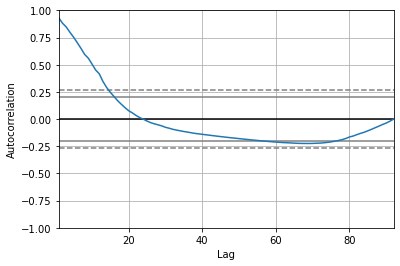

In [536]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Russia, a suitable window size might be around 7, as the values are most correalted for that range

In [537]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [539]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [540]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.0013812879586530906 test loss: 0.5617175430059433
Epoch 5 train loss: 0.009262055779104498 test loss: 0.394116192124784
Epoch 10 train loss: 0.004005239162478084 test loss: 0.24626169063458292
Epoch 15 train loss: 0.004562671663071625 test loss: 0.08525410881848075
Epoch 20 train loss: 0.004538089576270175 test loss: 0.5687619544565677
Epoch 25 train loss: 0.0032275452197221537 test loss: 0.09288386258849642
Epoch 30 train loss: 0.0033591395476973004 test loss: 0.3563695698976517
Epoch 35 train loss: 0.002542408971585112 test loss: 0.06350219708037912
Epoch 40 train loss: 0.0027662103315236036 test loss: 0.21304504813160746
Epoch 45 train loss: 0.002183107074675513 test loss: 0.04959993610391393
Epoch 50 train loss: 0.0024041697728902113 test loss: 0.13493047610390932
Epoch 55 train loss: 0.0019127815312588753 test loss: 0.04824020439823471
Epoch 60 train loss: 0.002225255395127125 test loss: 0.0893048943951726
Epoch 65 train loss: 0.0019481952396572081 test loss:

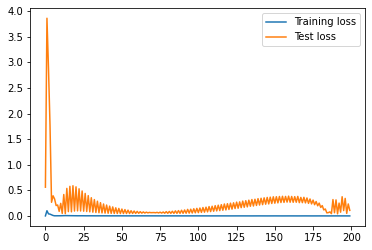

In [541]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [542]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.06415879726409912, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06415344774723053, 0.06435403227806091, 0.06427513062953949, 0.0640961080789566, 0.06440593302249908, 0.06607592105865479, 0.06519822776317596, 0.0644955188035965, 0.06510119140148163, 0.0644855946302414, 0.0647992342710495, 0.06559005379676819, 0.06872321665287018, 0.0685771107673645, 0.06614072620868683, 0.07012556493282318, 0.07270708680152893, 0.07251891493797302, 0.07884003221988678, 0.08071775734424591, 0.08044575154781342, 0.0827912986278534, 0.08591902256011963, 

In [543]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 2604 Actual 3388
Predicted 2962 Actual 3448
Predicted 3104 Actual 4070
Predicted 2345 Actual 4785
Predicted 3892 Actual 6060
Predicted 2297 Actual 4268
Predicted 3791 Actual 5642
Predicted 2641 Actual 5236
Predicted 3629 Actual 4774
Predicted 4306 Actual 5849
Predicted 2006 Actual 5965
Predicted 3987 Actual 6361
Predicted 2366 Actual 6198
Predicted 3892 Actual 6411
Predicted 2733 Actual 5841
Predicted 3439 Actual 7099
Predicted 4741 Actual 7933
Train RMSE =  164.34386386234388
Test RMSE =  2493.845553717791
RMSE Against Pakistan =  1749.9253045301944


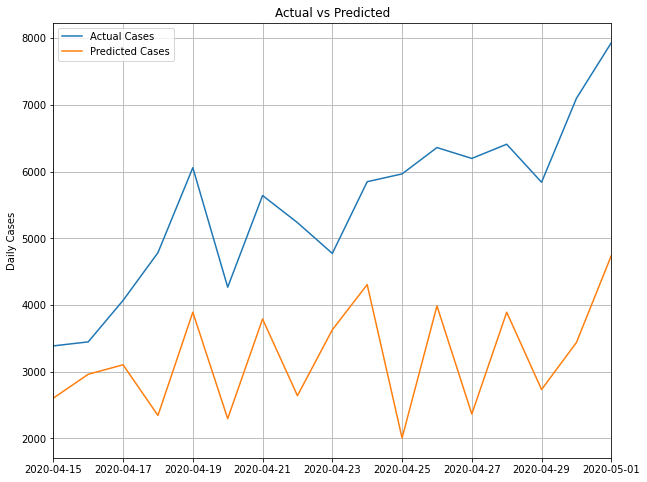

In [544]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

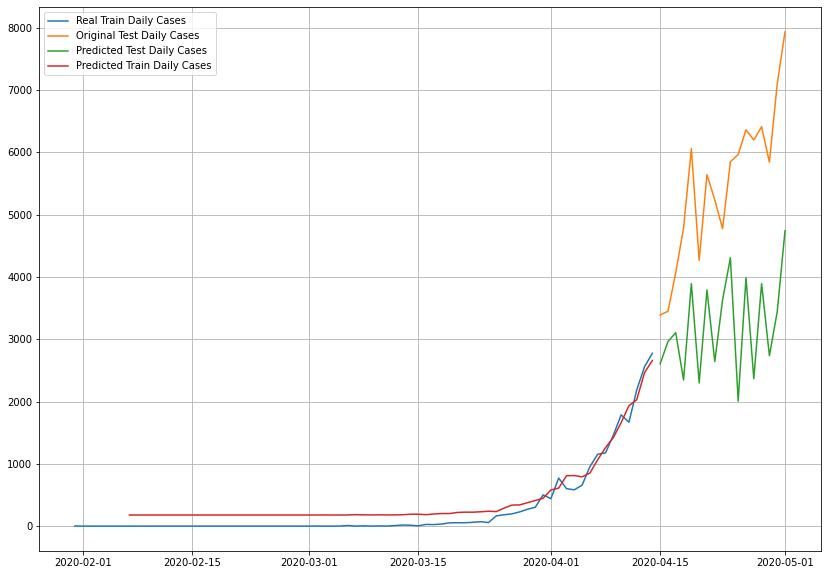

In [545]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

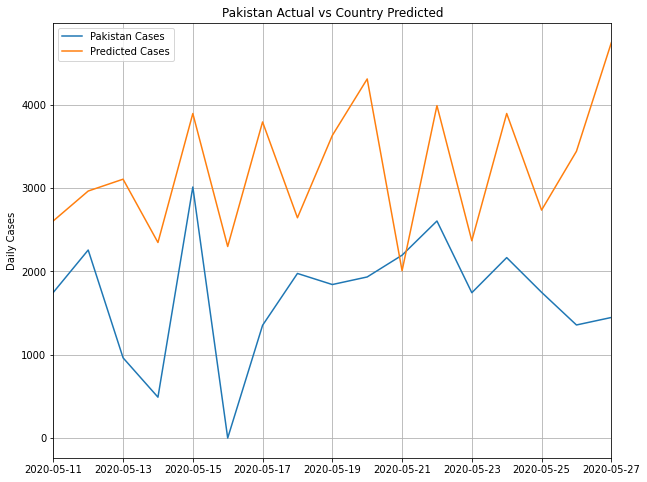

In [546]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [547]:
#CONFIGURATIONS
COUNTRY = "Russia"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

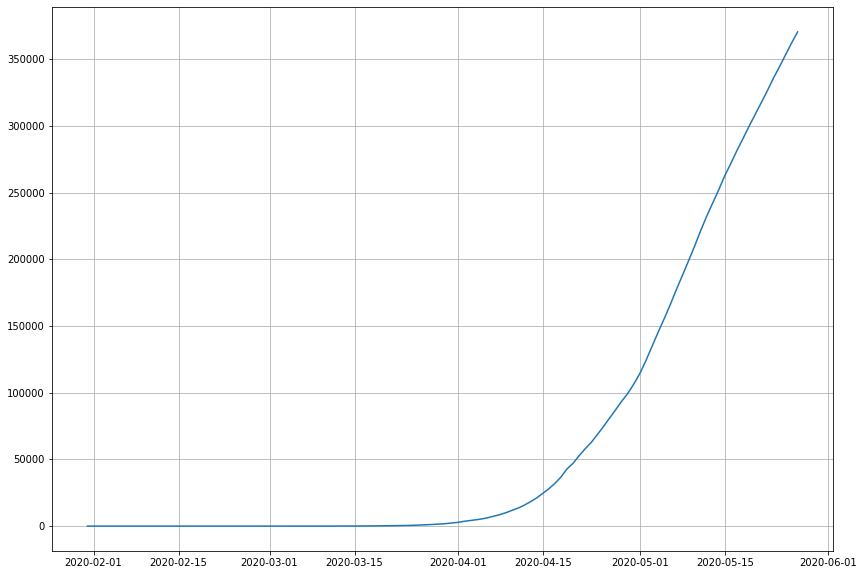

In [548]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

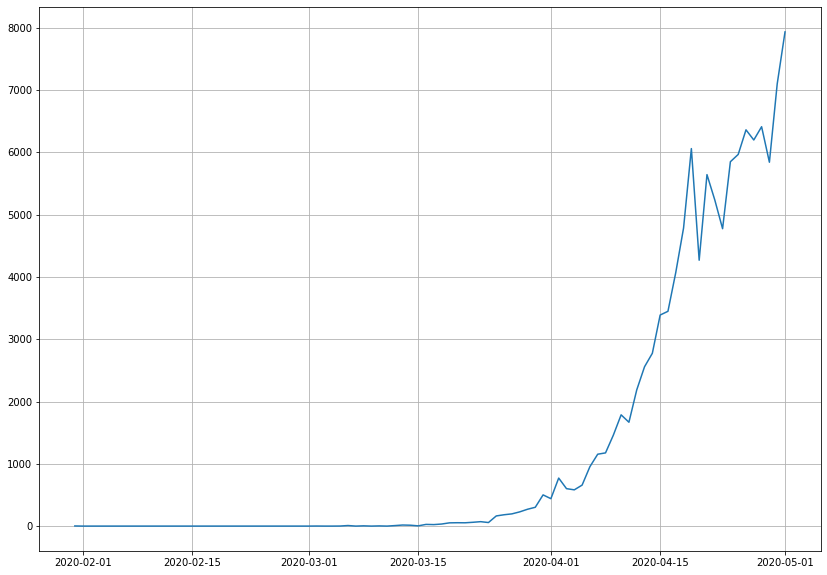

In [549]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

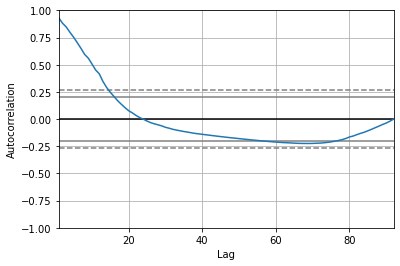

In [550]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Russia, a suitable window size might be around 7, as the values are most correalted for that range

In [551]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [553]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [561]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,500,train_seq)

Epoch 0 train loss: 0.001901915914235233
Epoch 5 train loss: 0.010209760985905552
Epoch 10 train loss: 0.004004092682212382
Epoch 15 train loss: 0.002655049085291668
Epoch 20 train loss: 0.002433615777282165
Epoch 25 train loss: 0.002389712977026088
Epoch 30 train loss: 0.002342021203923856
Epoch 35 train loss: 0.0022925482653853146
Epoch 40 train loss: 0.002246071588010026
Epoch 45 train loss: 0.002202382070555294
Epoch 50 train loss: 0.0021605007026554335
Epoch 55 train loss: 0.002120119990717484
Epoch 60 train loss: 0.002144668152239514
Epoch 65 train loss: 0.0020616860376427445
Epoch 70 train loss: 0.002003921861851159
Epoch 75 train loss: 0.0019927855634144635
Epoch 80 train loss: 0.0019895377692817724
Epoch 85 train loss: 0.0019605270235094705
Epoch 90 train loss: 0.0019452550056318519
Epoch 95 train loss: 0.0019380211061812216
Epoch 100 train loss: 0.0019196366380958138
Epoch 105 train loss: 0.0018997197445736697
Epoch 110 train loss: 0.0018877007124482148
Epoch 115 train loss: 

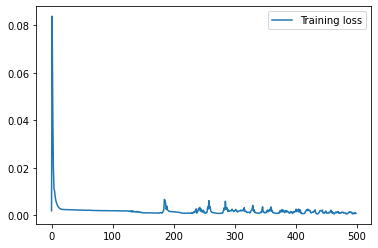

In [562]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [563]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.08278882503509521, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08278006315231323, 0.08286166191101074, 0.08281642198562622, 0.0827595591545105, 0.0828518271446228, 0.0835534930229187, 0.08308833837509155, 0.0829169750213623, 0.08283889293670654, 0.08296775817871094, 0.08286258578300476, 0.08342146873474121, 0.08443185687065125, 0.08440417051315308, 0.08319640159606934, 0.08471083641052246, 0.08555027842521667, 0.08585083484649658, 0.08757305145263672, 0.08831536769866943, 0.08782324194908142, 0.08832907676696777, 0.0894729495048523,

In [564]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  556.423677919436


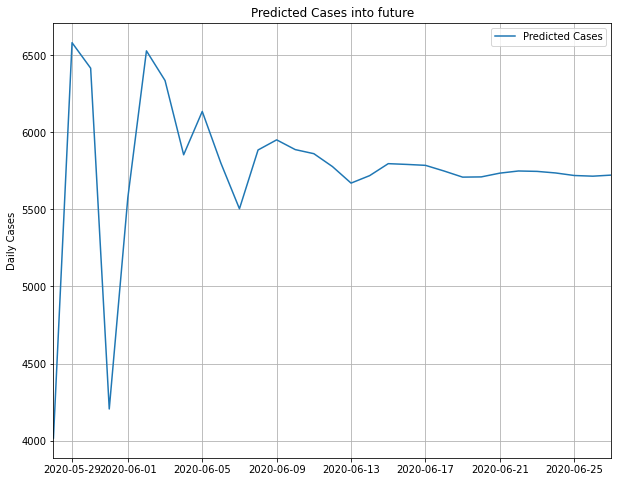

In [565]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

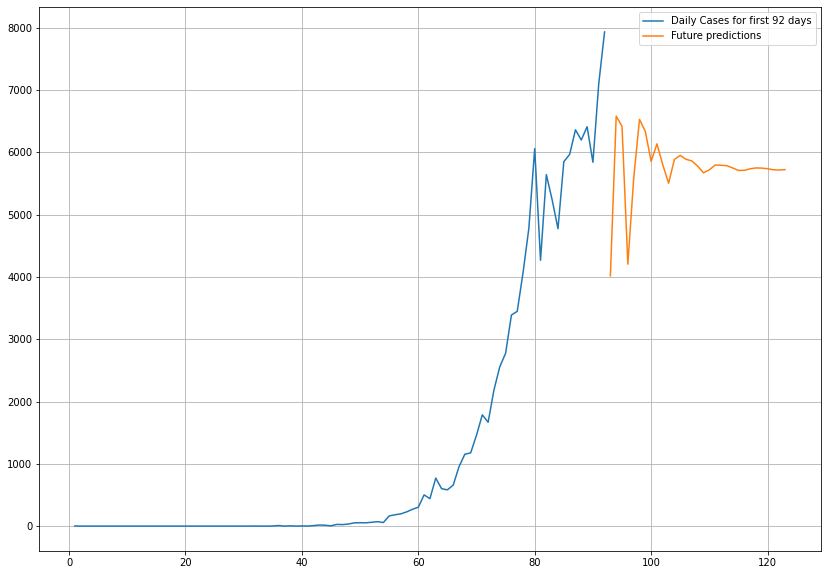

In [566]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Canada


#### Prediction from 10th May to 27th May

In [567]:
#CONFIGURATIONS
COUNTRY = "Canada"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

In [568]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

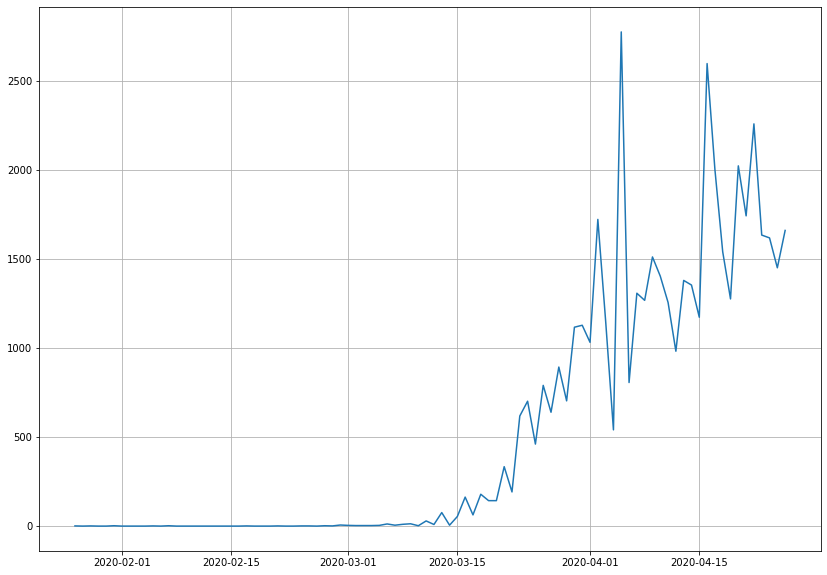

In [569]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

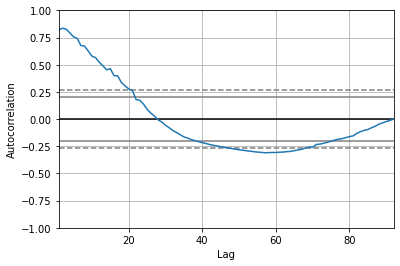

In [570]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Canada, a suitable window size might be around 7, as the values are most correalted for that range

In [572]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [574]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0004, 0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.0004])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000]), tensor([0.0007])), (tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0004, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor

In [590]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,150,train_seq,test_seq)

Epoch 0 train loss: 0.01079771608566957 test loss: 0.01222014136911298
Epoch 5 train loss: 0.019632185221942846 test loss: 0.026415289338910953
Epoch 10 train loss: 0.012341597836330558 test loss: 0.02149492361349985
Epoch 15 train loss: 0.010096601995613241 test loss: 0.01713939576293342
Epoch 20 train loss: 0.00844768531742686 test loss: 0.019746716875670246
Epoch 25 train loss: 0.006641583474919845 test loss: 0.045978421234030974
Epoch 30 train loss: 0.007593277529264158 test loss: 0.05396961619117065
Epoch 35 train loss: 0.006863126674878284 test loss: 0.06453215717920102
Epoch 40 train loss: 0.005618009930312486 test loss: 0.0865794989236747
Epoch 45 train loss: 0.005838100430801607 test loss: 0.06627377363120104
Epoch 50 train loss: 0.0067002915257870985 test loss: 0.08568644118495286
Epoch 55 train loss: 0.005573520467022941 test loss: 0.08895917879417539
Epoch 60 train loss: 0.004678765857779886 test loss: 0.10308110516052693
Epoch 65 train loss: 0.00477812218371465 test loss: 

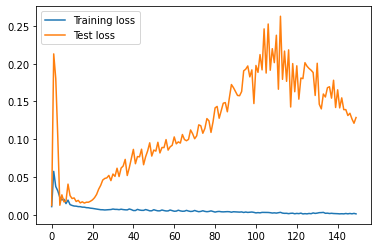

In [591]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [592]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.06709916889667511, 0.06679636240005493, 0.0665149986743927, 0.06663934886455536, 0.06680247187614441, 0.0668676495552063, 0.06689801812171936, 0.06702542304992676, 0.0667668879032135, 0.06654556095600128, 0.06664705276489258, 0.06669832766056061, 0.06663712859153748, 0.06662163138389587, 0.06662163138389587, 0.06662163138389587, 0.06672579050064087, 0.06685209274291992, 0.06668980419635773, 0.06656447052955627, 0.06673464179039001, 0.06689043343067169, 0.06669752299785614, 0.06666865944862366, 0.0669650137424469, 0.06695877015590668, 0.06684862077236176, 0.06713822484016418, 0.06766000390052795, 0.06842061877250671, 0.06823556125164032, 0.06764088571071625, 0.06770801544189453, 0.06803624331951141, 0.06905058026313782, 0.07018625736236572, 0.06957150995731354, 0.0701042115688324, 0.0705227181315422, 0.07094235718250275, 0.07400691509246826, 0.07892648875713348, 0.08436846733093262, 0.07843373715877533, 0.09281555563211441, 0.11596783250570297, 0.11072191596031189, 

In [593]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1205 Actual 1405
Predicted 1345 Actual 1257
Predicted 1299 Actual 983
Predicted 813 Actual 1381
Predicted 2078 Actual 1355
Predicted 1031 Actual 1174
Predicted 1189 Actual 2600
Predicted 3978 Actual 2005
Predicted 643 Actual 1542
Predicted 165 Actual 1277
Predicted 6596 Actual 2025
Predicted 899 Actual 1744
Predicted 1938 Actual 2261
Predicted 1144 Actual 1636
Predicted 1309 Actual 1620
Predicted 1295 Actual 1452
Predicted 1097 Actual 1662
Train RMSE =  169.9752783932154
Test RMSE =  1357.690548544083
RMSE Against Pakistan =  1446.2357234080418


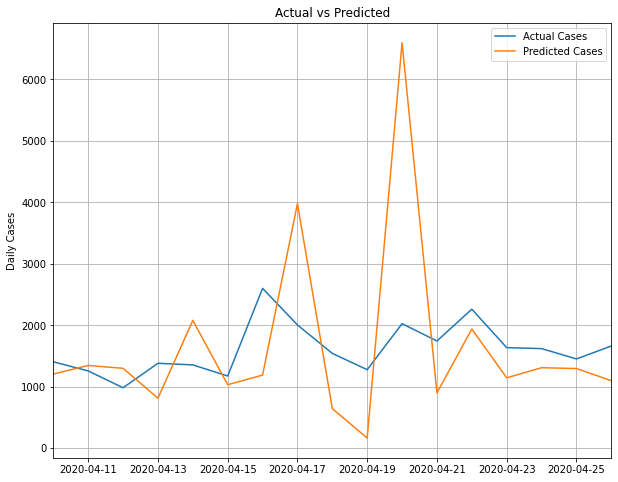

In [594]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

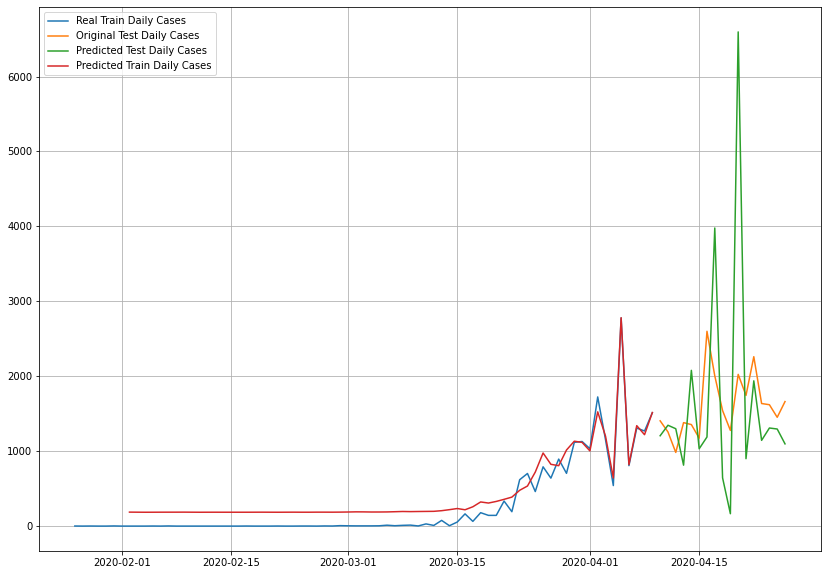

In [595]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

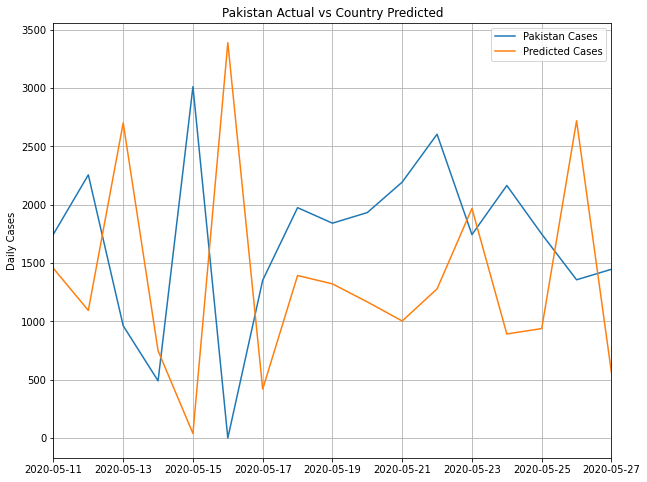

In [317]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [596]:
#CONFIGURATIONS
COUNTRY = "Canada"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

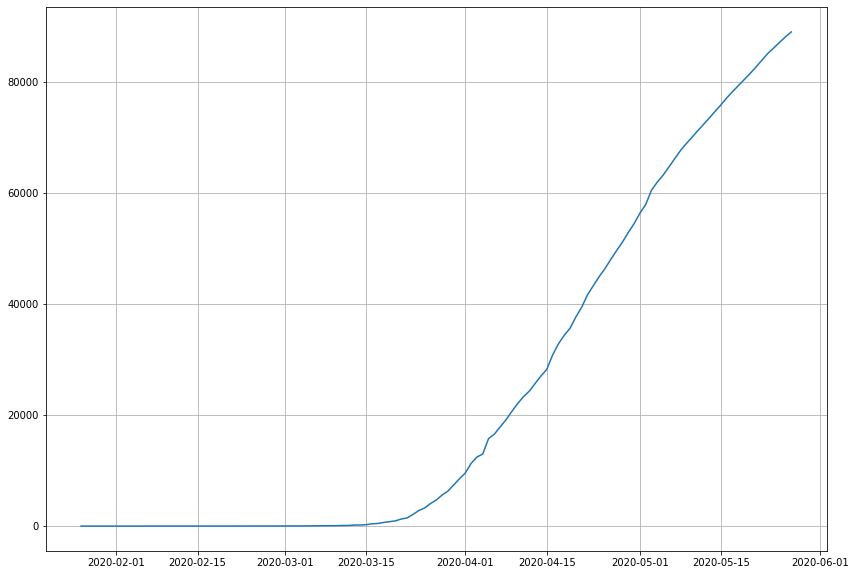

In [597]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

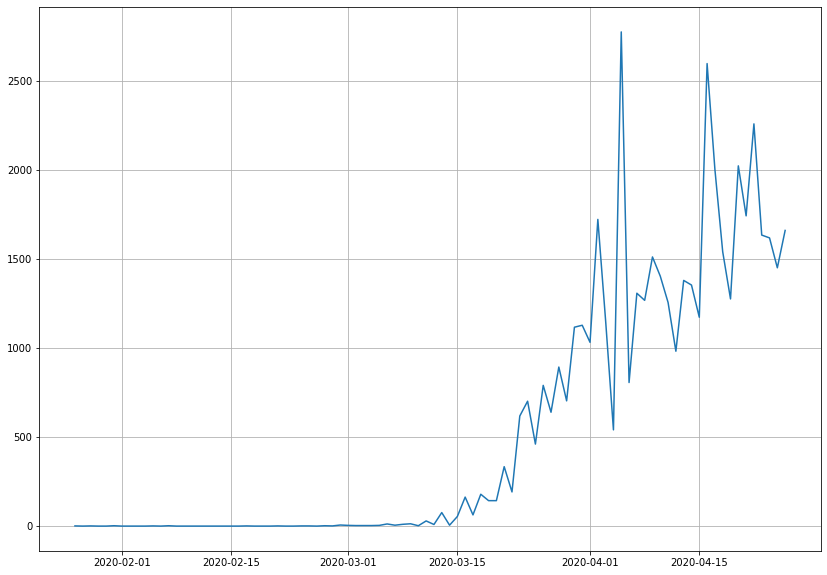

In [598]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

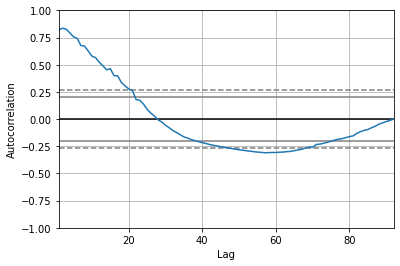

In [599]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Canada, a suitable window size might be around 4, as the values are most correalted for that range

In [600]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 4
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [602]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0004, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0000]), tensor([0.0007])), (tensor([0.0004, 0.0000, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.0004])), (tensor([0.0000, 0.0000, 0.0000, 0.0004]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0004, 0.0000]), tensor([0.0007])), (tensor([0.0000, 0.0004, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.00

In [603]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq)

Epoch 0 train loss: 0.017026921881169402
Epoch 5 train loss: 0.01975320943720569
Epoch 10 train loss: 0.012490379182101467
Epoch 15 train loss: 0.011391212570641523
Epoch 20 train loss: 0.011146006889626263
Epoch 25 train loss: 0.01098683364653551
Epoch 30 train loss: 0.010838797819162062
Epoch 35 train loss: 0.010712121847711349
Epoch 40 train loss: 0.010607225989186987
Epoch 45 train loss: 0.010517593906171392
Epoch 50 train loss: 0.010437748611452979
Epoch 55 train loss: 0.010363194003264546
Epoch 60 train loss: 0.010283796303893629
Epoch 65 train loss: 0.01020124605352875
Epoch 70 train loss: 0.010108589738324123
Epoch 75 train loss: 0.009998007158107725
Epoch 80 train loss: 0.009852707475939875
Epoch 85 train loss: 0.009762096370699953
Epoch 90 train loss: 0.009471762568791918
Epoch 95 train loss: 0.009489134681776291
Epoch 100 train loss: 0.00952111726931213
Epoch 105 train loss: 0.008866163045156063
Epoch 110 train loss: 0.00895003564046199
Epoch 115 train loss: 0.00868540679552

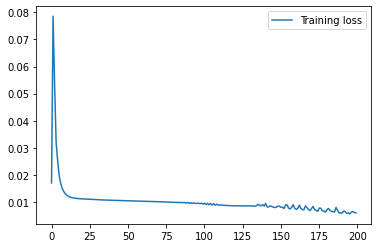

In [604]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [605]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.06214527785778046, 0.06207592785358429, 0.062218427658081055, 0.06217060983181, 0.062114015221595764, 0.062119945883750916, 0.062038809061050415, 0.062108322978019714, 0.06210474669933319, 0.062214747071266174, 0.062211304903030396, 0.062114015221595764, 0.062119945883750916, 0.062038809061050415, 0.062038809061050415, 0.062038809061050415, 0.062038809061050415, 0.062038809061050415, 0.062038809061050415, 0.062108322978019714, 0.06210474669933319, 0.06207592785358429, 0.06207917630672455, 0.062108322978019714, 0.06210474669933319, 0.06207592785358429, 0.06214877963066101, 0.062174245715141296, 0.062141746282577515, 0.062254711985588074, 0.06228090822696686, 0.06259602308273315, 0.06283025443553925, 0.06278136372566223, 0.06283597648143768, 0.06271746754646301, 0.0627463310956955, 0.06337021291255951, 0.06344248354434967, 0.06369800865650177, 0.06429502367973328, 0.06361781060695648, 0.06509272754192352, 0.06522901356220245, 0.06928522884845734, 0.06903792917728424,

In [606]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  215.04244312587633


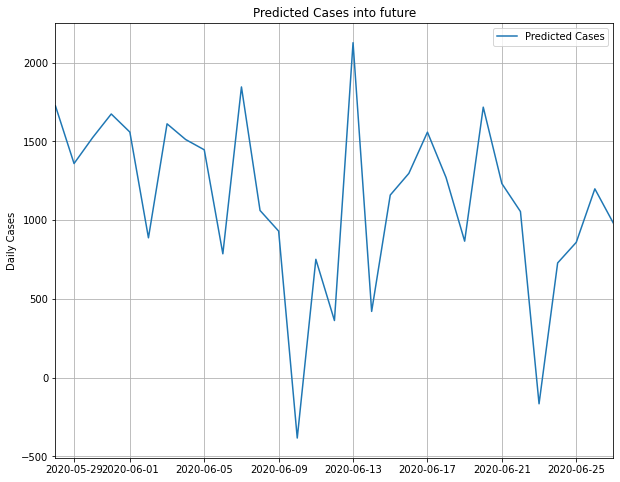

In [607]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

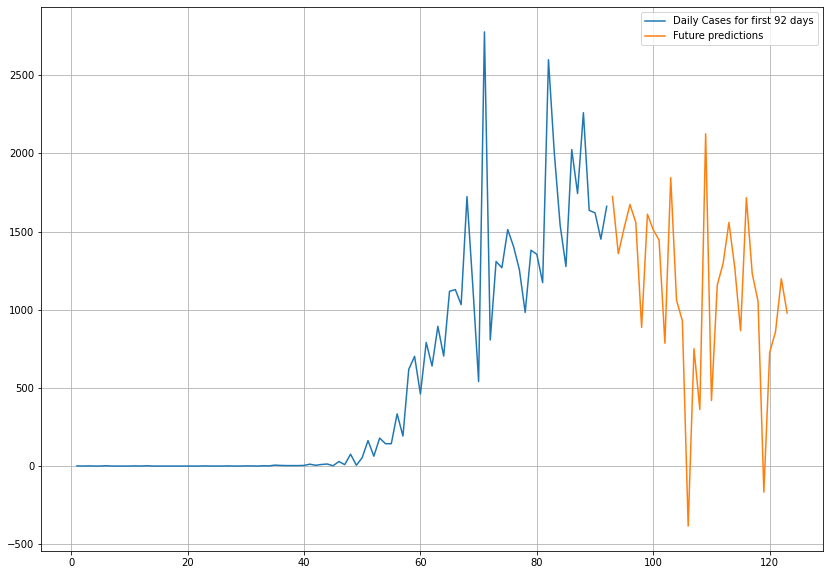

In [608]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Pakistan


#### Prediction from 10th May to 27th May

In [609]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

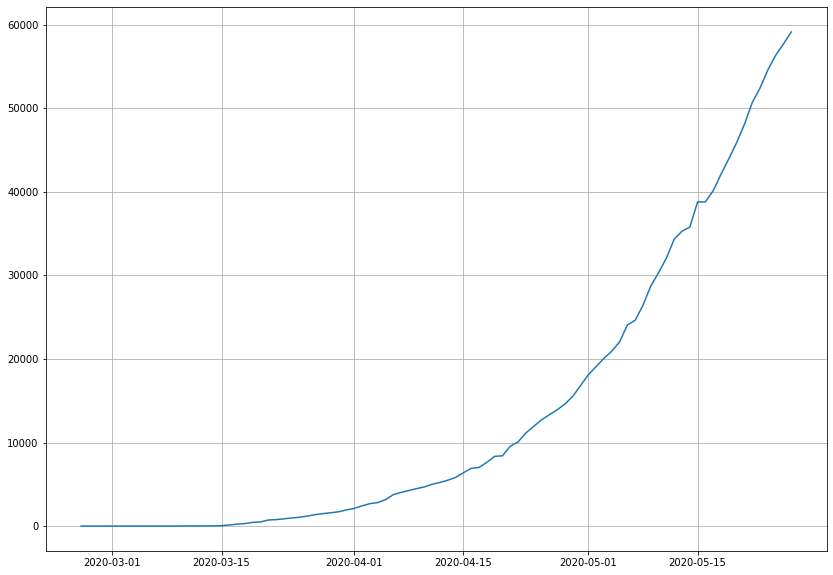

In [610]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

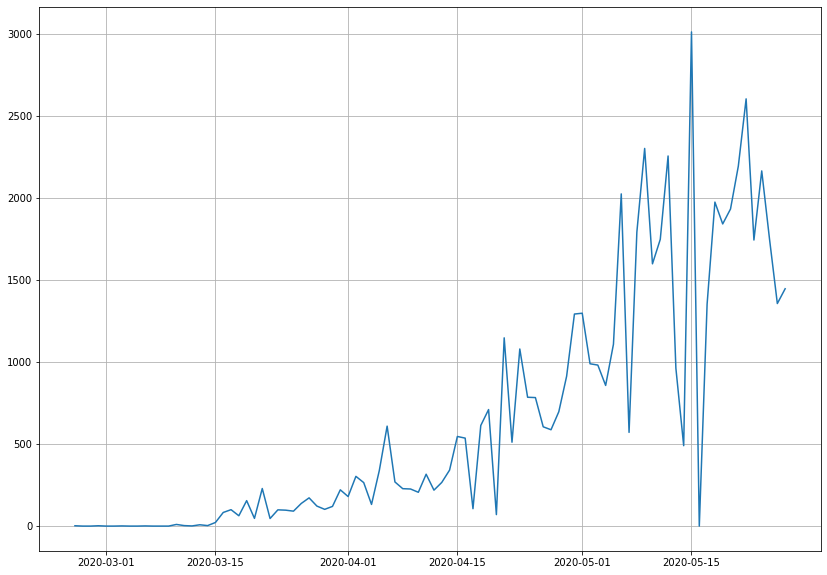

In [611]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

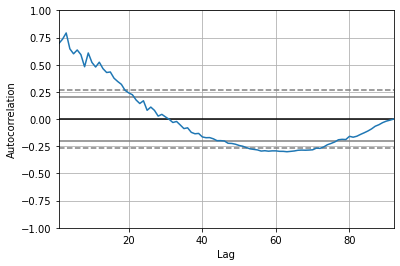

In [612]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 10, as the values are most correalted for that range

In [613]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [615]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0007, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0003, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0000]), tensor([0.0033])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0033]), tensor([0.0010])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0033, 0.0010]), tensor([0.0003])), (tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0033, 0.0010, 0.0003]), tensor([0.0027])), (tensor([0.0000, 0.0000, 0.0000, 0.0033, 0.0010, 0.0003, 0.0027]), tensor([0.0010])), (tensor([0.0000, 0.0000, 0.0033, 0.0010, 0.0003, 0.0027, 0.0010]), tensor

In [622]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,300,train_seq,test_seq)

Epoch 0 train loss: 0.007794854503658525 test loss: 0.02289391609374434
Epoch 5 train loss: 0.014264057120689866 test loss: 0.15694808128318982
Epoch 10 train loss: 0.008003758616825628 test loss: 0.15017574156008778
Epoch 15 train loss: 0.00781898926795614 test loss: 0.11671402589126956
Epoch 20 train loss: 0.007707771663369974 test loss: 0.10308571546484017
Epoch 25 train loss: 0.00765385886029508 test loss: 0.09867752940174342
Epoch 30 train loss: 0.007621664008805804 test loss: 0.09908850552558021
Epoch 35 train loss: 0.007598049559510358 test loss: 0.10225295643995196
Epoch 40 train loss: 0.007577953990728633 test loss: 0.10697849587995734
Epoch 45 train loss: 0.0075591891278590706 test loss: 0.11256271906695474
Epoch 50 train loss: 0.007540164324654508 test loss: 0.1186436719912436
Epoch 55 train loss: 0.007518998870351744 test loss: 0.1250776440720074
Epoch 60 train loss: 0.00749246691480695 test loss: 0.13187009759567445
Epoch 65 train loss: 0.007463543246218386 test loss: 0.14

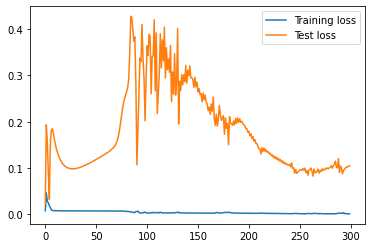

In [623]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [624]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.051297470927238464, 0.05114780366420746, 0.05121666193008423, 0.05122934281826019, 0.05113871395587921, 0.05124594271183014, 0.051175013184547424, 0.052064478397369385, 0.051250964403152466, 0.052475541830062866, 0.05293962359428406, 0.051725491881370544, 0.05396927893161774, 0.05880102515220642, 0.06184940040111542, 0.06741772592067719, 0.08356781303882599, 0.06724818050861359, 0.09497862309217453, 0.06095246970653534, 0.09086522459983826, 0.0705740749835968, 0.0702059417963028, 0.07285137474536896, 0.07208283245563507, 0.07950736582279205, 0.08552426099777222, 0.0826273113489151, 0.08346433937549591, 0.07497066259384155, 0.1021115630865097, 0.0982474684715271, 0.10547544062137604, 0.12999659776687622, 0.10683329403400421, 0.10476310551166534, 0.14322130382061005, 0.11059613525867462, 0.09506447613239288, 0.10114429891109467, 0.09598029404878616, 0.11703019589185715, 0.10495500266551971, 0.1292489916086197, 0.12353703379631042, 0.13189947605133057, 0.2228004783391

In [625]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 2413 Actual 1747
Predicted 1641 Actual 2255
Predicted 1434 Actual 961
Predicted 1734 Actual 490
Predicted 1774 Actual 3011
Predicted 1534 Actual 0
Predicted 2375 Actual 1352
Predicted 1184 Actual 1974
Predicted 1930 Actual 1841
Predicted 1944 Actual 1932
Predicted 2163 Actual 2193
Predicted 1300 Actual 2603
Predicted 694 Actual 1743
Predicted 1107 Actual 2164
Predicted 1314 Actual 1748
Predicted 1236 Actual 1356
Predicted 1120 Actual 1446
Train RMSE =  116.53578408816006
Test RMSE =  853.2917301281226
RMSE Against Pakistan =  853.2917315119255


In [626]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

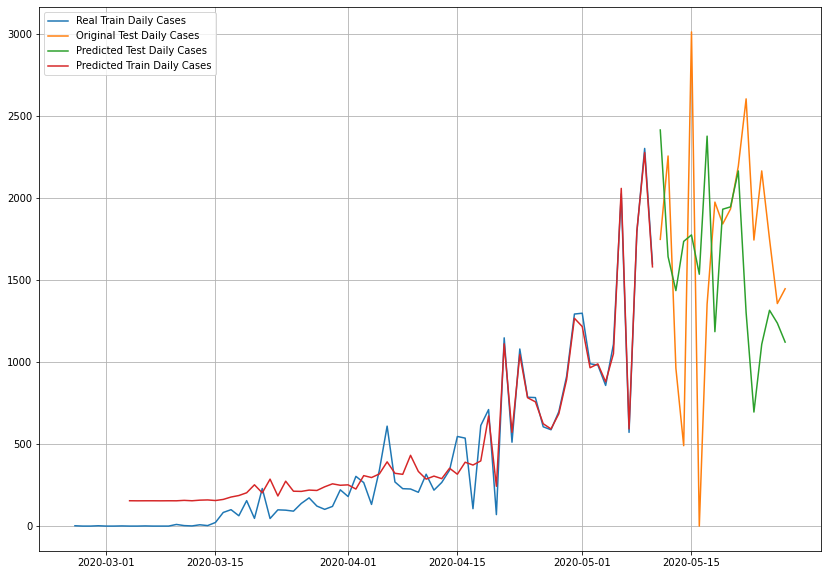

In [627]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [628]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

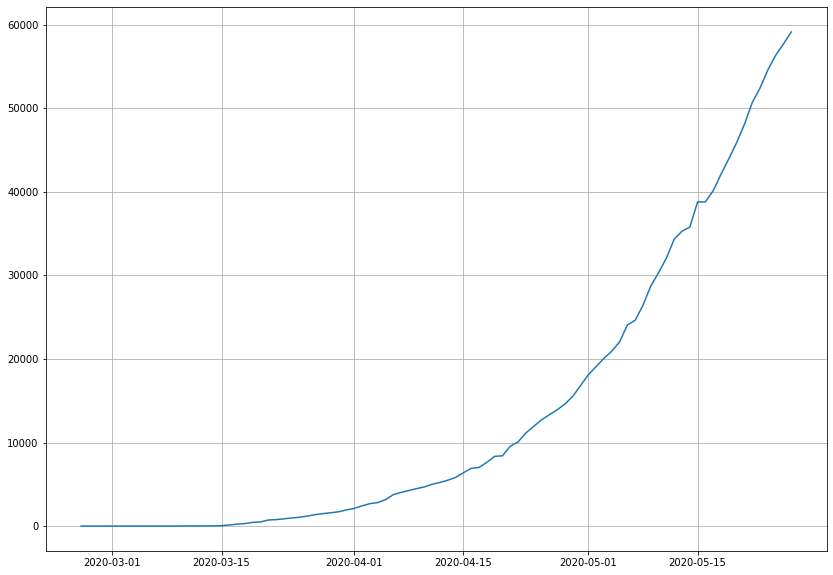

In [629]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

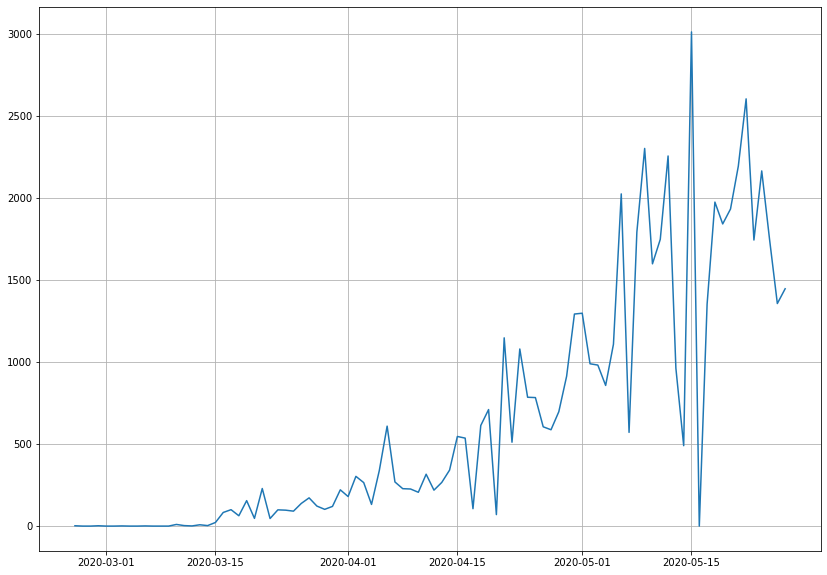

In [630]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

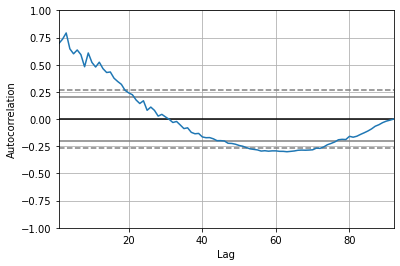

In [631]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 5, as the values are most correalted for that range

In [632]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [634]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0003, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0000]), tensor([0.0033])), (tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0033]), tensor([0.0010])), (tensor([0.0000, 0.0000, 0.0000, 0.0033, 0.0010]), tensor([0.0003])), (tensor([0.0000, 0.0000, 0.0033, 0.0010, 0.0003]), tensor([0.0027])), (tensor([0.0000, 0.0033, 0.0010, 0.0003, 0.0027]), tensor([0.0010])), (tensor([0.0033, 0.0010, 0.0003, 0.0027, 0.0010]), tensor([0.0073])), (tensor([0.0010, 0.0003, 0.0027, 0.0010, 0.

In [635]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,300,train_seq)

Epoch 0 train loss: 0.019282933975771587
Epoch 5 train loss: 0.03284776706386061
Epoch 10 train loss: 0.021333441144541526
Epoch 15 train loss: 0.017824898544892182
Epoch 20 train loss: 0.01582392930132123
Epoch 25 train loss: 0.015298992317623524
Epoch 30 train loss: 0.014985039452534597
Epoch 35 train loss: 0.014546660676759315
Epoch 40 train loss: 0.013328049705529369
Epoch 45 train loss: 0.014003629321673691
Epoch 50 train loss: 0.012037985836701572
Epoch 55 train loss: 0.013040117709090004
Epoch 60 train loss: 0.011254324033621846
Epoch 65 train loss: 0.010633867807890293
Epoch 70 train loss: 0.009844783815599738
Epoch 75 train loss: 0.009189746518604911
Epoch 80 train loss: 0.00867655806165424
Epoch 85 train loss: 0.008288362027652228
Epoch 90 train loss: 0.008001484017746183
Epoch 95 train loss: 0.007731906016940344
Epoch 100 train loss: 0.010064467266444034
Epoch 105 train loss: 0.007477663402053719
Epoch 110 train loss: 0.007633998570237174
Epoch 115 train loss: 0.007368215622

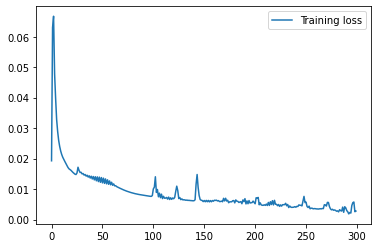

In [636]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [637]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.030037373304367065, 0.0300714373588562, 0.029904335737228394, 0.03000466525554657, 0.02996291220188141, 0.02988813817501068, 0.02994583547115326, 0.02996291220188141, 0.02987067401409149, 0.030087977647781372, 0.03023533523082733, 0.031060591340065002, 0.030517175793647766, 0.030922815203666687, 0.03140801191329956, 0.032578423619270325, 0.037668392062187195, 0.045153722167015076, 0.05035467445850372, 0.05288243293762207, 0.06495235115289688, 0.05458648502826691, 0.07903899252414703, 0.049094393849372864, 0.06871108710765839, 0.053184524178504944, 0.05989890545606613, 0.06756362318992615, 0.07017980515956879, 0.06686532497406006, 0.06908918172121048, 0.07193779945373535, 0.0874071791768074, 0.09454759955406189, 0.12449011951684952, 0.10812973976135254, 0.12270950525999069, 0.18563354015350342, 0.1932390332221985, 0.14378786087036133, 0.17525634169578552, 0.11578063666820526, 0.11389397084712982, 0.1281818151473999, 0.11512415111064911, 0.15283888578414917, 0.184241

In [638]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  142.72796339137423


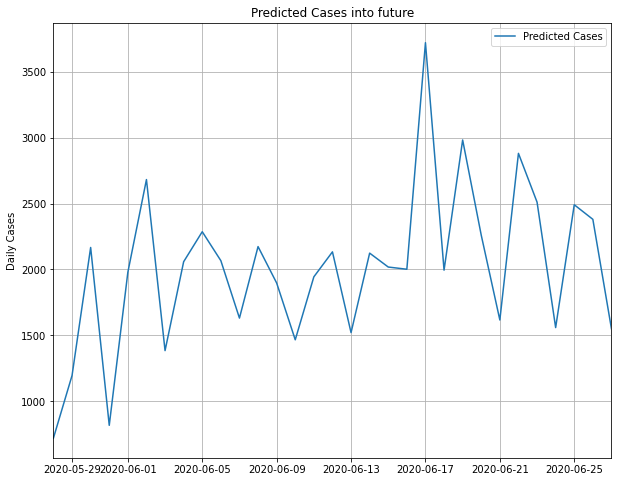

In [639]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

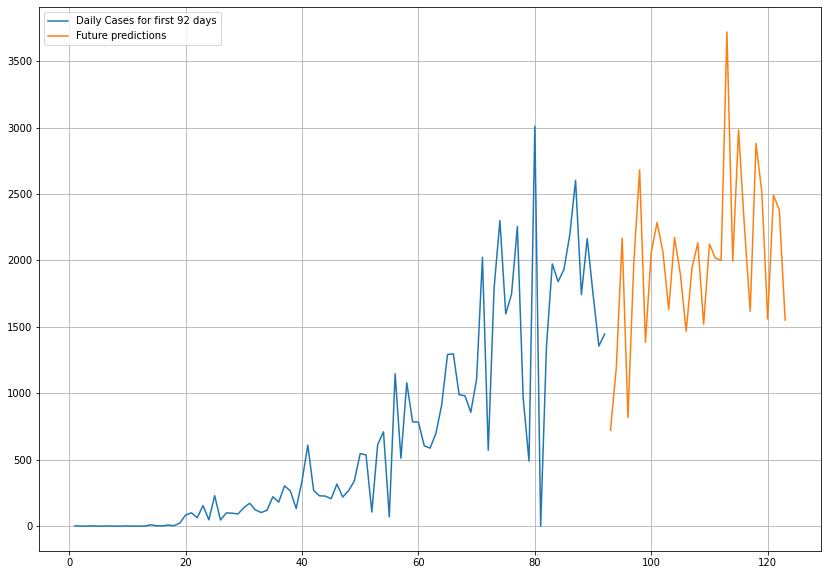

In [640]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

## Approach 2 (LSTM, trained on stationary series)

In [385]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

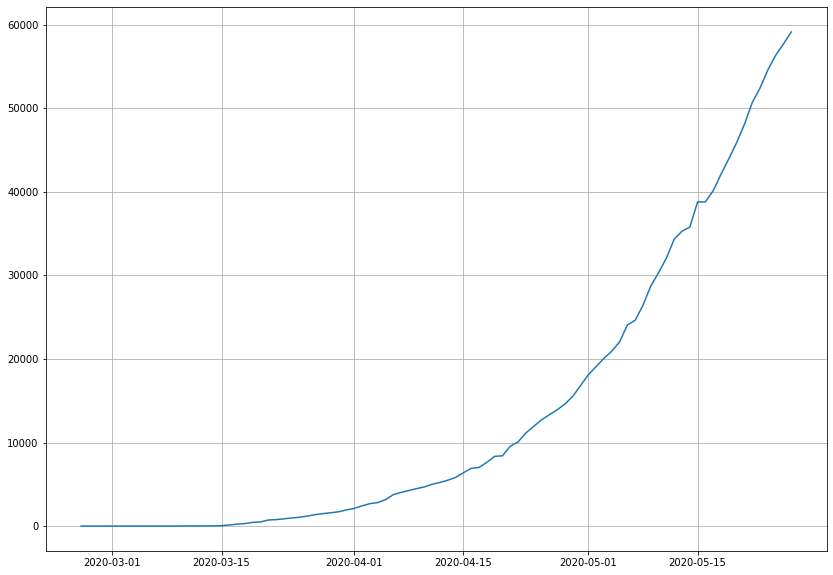

In [386]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

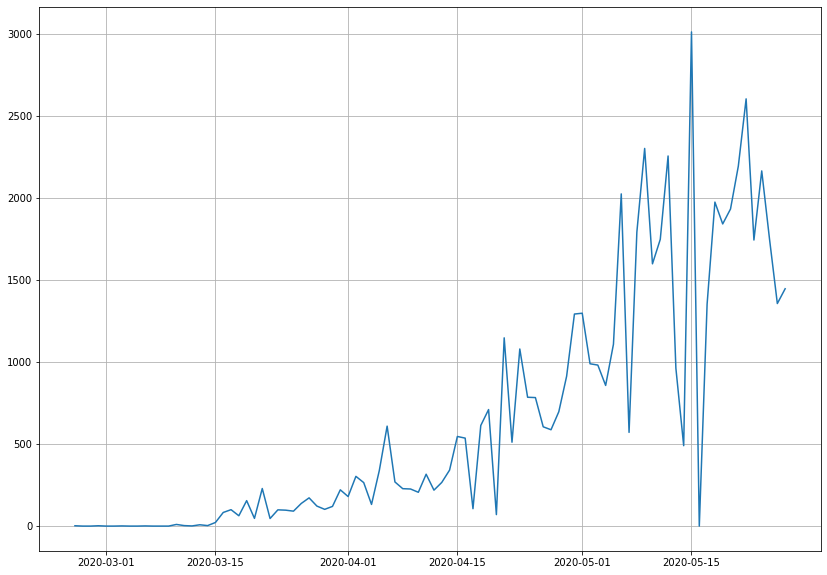

In [387]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

In [0]:
def makeSeriesStationary(series):
    abc = series - series.shift()
    abc.fillna(0,inplace = True)
    return abc
def reverseStationarySeries(series,start,index):
    abc = pd.Series(series, copy=True)
    abc_cumsum = abc.cumsum()
    temp = pd.Series(start,index)
    temp = temp.add(abc_cumsum,fill_value=0)
    return temp

def reverseStationarySeries3(series,start):
    abc = pd.Series(series)
    for x in range(1,len(abc)):
      abc[x] = abc[x] + abc[x-1]
    for x in range(len(abc)):
      abc[x] = abc[x] + start
    abc = pd.Series(abc)
    return abc

def compare(sr1, sr2):
  diff = 0
  for x,y in enumerate(sr1):
    diff += abs(y) - abs(sr2[x])
  return diff

In [389]:
daily_cases_log = np.log(daily_cases + 1)
daily_cases2 = makeSeriesStationary(daily_cases_log)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases2)

2020-02-26       2.0
2020-02-27       0.0
2020-02-28       0.0
2020-02-29       2.0
2020-03-01       0.0
               ...  
2020-05-23    1743.0
2020-05-24    2164.0
2020-05-25    1748.0
2020-05-26    1356.0
2020-05-27    1446.0
Length: 92, dtype: float64
2020-02-26      0.0
2020-02-27     -2.0
2020-02-28      0.0
2020-02-29      2.0
2020-03-01     -2.0
              ...  
2020-05-23   -860.0
2020-05-24    421.0
2020-05-25   -416.0
2020-05-26   -392.0
2020-05-27     90.0
Length: 92, dtype: float64


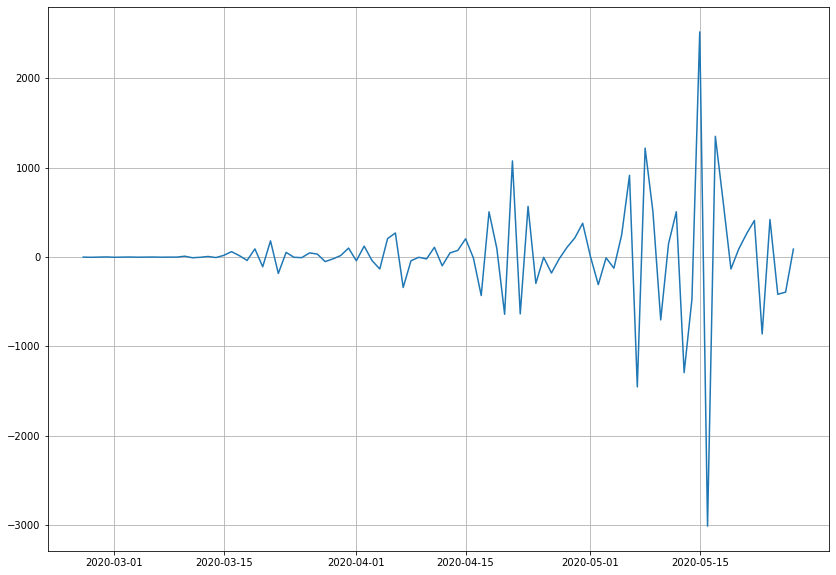

In [390]:
print(daily_cases)
daily_cases2 = makeSeriesStationary(daily_cases)
print(daily_cases2)
daily_cases3 = reverseStationarySeries(daily_cases2,daily_cases[0],daily_cases.index)
# print(daily_cases3)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases2)

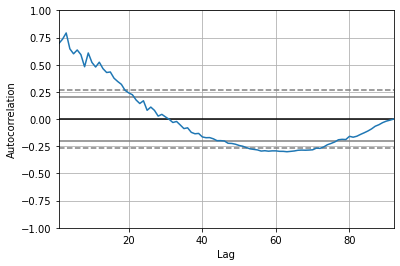

In [391]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 6, as the values are most correalted for that range

In [392]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
# daily_cases = makeSeriesStationary(daily_cases)
WINDOW_SIZE = 6
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
# train_data_log = np.log(train_data + 1)
# test_data_log = np.log(test_data + 1)
train_data_stat = makeSeriesStationary(train_data)
test_data_stat = makeSeriesStationary(test_data)
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler((-1,1))
train_data_normalized = scaler.fit_transform(train_data_stat.values.reshape(-1,1))
test_data_normalized = scaler.fit_transform(test_data_stat.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [394]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0872, 0.0857, 0.0872, 0.0887, 0.0857, 0.0872]), tensor([0.0879])), (tensor([0.0857, 0.0872, 0.0887, 0.0857, 0.0872, 0.0879]), tensor([0.0864])), (tensor([0.0872, 0.0887, 0.0857, 0.0872, 0.0879, 0.0864]), tensor([0.0872])), (tensor([0.0887, 0.0857, 0.0872, 0.0879, 0.0864, 0.0872]), tensor([0.0879])), (tensor([0.0857, 0.0872, 0.0879, 0.0864, 0.0872, 0.0879]), tensor([0.0864])), (tensor([0.0872, 0.0879, 0.0864, 0.0872, 0.0879, 0.0864]), tensor([0.0872])), (tensor([0.0879, 0.0864, 0.0872, 0.0879, 0.0864, 0.0872]), tensor([0.0872])), (tensor([0.0864, 0.0872, 0.0879, 0.0864, 0.0872, 0.0872]), tensor([0.0947])), (tensor([0.0872, 0.0879, 0.0864, 0.0872, 0.0872, 0.0947]), tensor([0.0819])), (tensor([0.0879, 0.0864, 0.0872, 0.0872, 0.0947, 0.0819]), tensor([0.0857])), (tensor([0.0864, 0.0872, 0.0872, 0.0947, 0.0819, 0.0857]), tensor([0.0924])), (tensor([0.0872, 0.0872, 0.0947, 0.0819, 0.0857, 0.0924]), tensor([0.0834])), (tensor([0.0872, 0.0947, 0.0819, 0.0857, 0.0924, 0.0834]), tens

In [395]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,200,train_seq,test_seq)

Epoch 0 train loss: 0.06956934985048173 test loss: 0.038656531549515254
Epoch 5 train loss: 0.04820668356891461 test loss: 0.026225072268227286
Epoch 10 train loss: 0.034792897449110356 test loss: 0.04928416488043943
Epoch 15 train loss: 0.03151114930248392 test loss: 0.07388893237723758
Epoch 20 train loss: 0.030079583372502963 test loss: 0.09413835838098418
Epoch 25 train loss: 0.028767816616812564 test loss: 0.1214603813873096
Epoch 30 train loss: 0.027541496544191545 test loss: 0.15972482988780196
Epoch 35 train loss: 0.026482182401960545 test loss: 0.19518986767665905
Epoch 40 train loss: 0.024290065213358008 test loss: 0.24414338856215842
Epoch 45 train loss: 0.02170156534256144 test loss: 0.2693007660669867
Epoch 50 train loss: 0.019983889032559637 test loss: 0.2217006768015298
Epoch 55 train loss: 0.01740809202114956 test loss: 0.18712585274955595
Epoch 60 train loss: 0.01619313700921075 test loss: 0.14065625445271673
Epoch 65 train loss: 0.01622857737746254 test loss: 0.083952

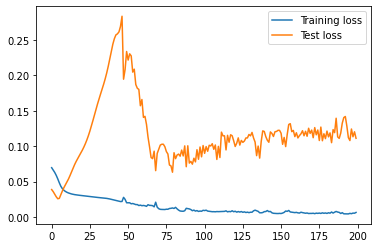

In [396]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [397]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.11854640394449234, 0.12143179774284363, 0.11864952743053436, 0.11737694591283798, 0.12047275900840759, 0.11868716776371002, 0.11835591495037079, 0.12041634321212769, 0.11527422815561295, 0.11396704614162445, 0.12112480401992798, 0.12631145119667053, 0.11876102536916733, 0.1036994531750679, 0.09194894134998322, 0.06558359414339066, 0.09762068092823029, 0.1362794190645218, 0.17131945490837097, 0.08505017310380936, 0.13937503099441528, 0.1530182659626007, 0.16353993117809296, 0.1723576933145523, 0.09315869212150574, 0.060812726616859436, 0.07230836153030396, 0.15738093852996826, 0.19880712032318115, 0.06290016323328018, 0.012815378606319427, 0.08404047042131424, 0.14322534203529358, 0.20655691623687744, 0.19086742401123047, -0.112877756357193, 0.01768644154071808, 0.06932084262371063, 0.11110999435186386, 0.21485555171966553, 0.060545414686203, 0.16375353932380676, 0.12054190039634705, 0.14249613881111145, 0.019140541553497314, -0.10415561497211456, 0.3669954538345337

In [0]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))

In [401]:
train_idx = daily_cases.index[WINDOW_SIZE:len(train_pred)+WINDOW_SIZE]
train_pred2 = reverseStationarySeries3(train_pred.flatten(),train_data[WINDOW_SIZE])
# train_pred2 = reverseStationarySeries3(train_pred.flatten(),train_data_log[WINDOW_SIZE])
# train_pred2 = np.exp(train_pred2)
print(train_pred2)

0       83.899353
1      174.779706
2      257.964299
3      337.628931
4      425.856583
         ...     
64    5672.610710
65    2798.465359
66    5556.672895
67    6521.238503
68    5488.413550
Length: 69, dtype: float64


In [402]:
test_idx = daily_cases.index[len(train_data):]
actual_predictions2 = reverseStationarySeries3(actual_predictions.flatten(),test_data[0])
# actual_predictions2 = reverseStationarySeries3(actual_predictions.flatten(),test_data_log[0])
# actual_predictions2 = np.exp(actual_predictions2)
print(actual_predictions2)

0     3593.998760
1     1691.828496
2     3277.584994
3     3897.920671
4     2645.581154
5     4261.295864
6     2414.921681
7     3934.323720
8     4712.769288
9     3232.344377
10    5116.444353
11    3233.048091
12    4879.466703
13    5460.953663
14    4273.851964
15    5783.843097
16    3965.688774
dtype: float64


In [403]:
real_values2 = reverseStationarySeries3(real_values.flatten(),test_data[0])
# real_values2 = reverseStationarySeries3(real_values.flatten(),test_data_log[0])
# real_values2 = np.exp(real_values2) - 1
print(real_values2)
print(compare(real_values2,test_data))

0     1747.000000
1     2255.000000
2      961.999878
3      489.999878
4     3011.000000
5       -0.000122
6     1351.999756
7     1973.999756
8     1840.999756
9     1931.999756
10    2192.999756
11    2602.999756
12    1742.999756
13    2163.999756
14    1747.999756
15    1355.999756
16    1445.999756
dtype: float32
-0.0028076171875


In [404]:
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions2[x]),"Actual",int(real_values2[x]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred2))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values2,actual_predictions2))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions2))
print("RMSE Against Pakistan = ",pak_rms)

Test cases prediction
Predicted 3593 Actual 1747
Predicted 1691 Actual 2255
Predicted 3277 Actual 961
Predicted 3897 Actual 489
Predicted 2645 Actual 3011
Predicted 4261 Actual 0
Predicted 2414 Actual 1351
Predicted 3934 Actual 1973
Predicted 4712 Actual 1840
Predicted 3232 Actual 1931
Predicted 5116 Actual 2192
Predicted 3233 Actual 2602
Predicted 4879 Actual 1742
Predicted 5460 Actual 2163
Predicted 4273 Actual 1747
Predicted 5783 Actual 1355
Predicted 3965 Actual 1445
Train RMSE =  2211.7028620350216
Test RMSE =  2610.9791598501693
RMSE Against Pakistan =  2610.97898577581


In [405]:
fig,axs = plt.subplots(1,2,figsize=(15,8))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle("Actual vs Predicted", fontsize=16)
axs[0].set_title('Actual vs Predicted Stationary Scale')
axs[0].grid(True)
axs[0].autoscale(axis='x', tight=True)
axs[0].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
axs[0].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
axs[0].legend(loc='upper left')
axs[1].grid(True)
axs[1].autoscale(axis='x', tight=True)
axs[1].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values2,label = "Actual Cases")
axs[1].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions2, label = "Predicted Cases")
axs[1].set_title('Actual vs Predicted Original Scale')
axs[1].legend(loc='upper left')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Daily Cases')

In [406]:
fig,axs = plt.subplots(1,2,figsize=(15,8))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle("Actual vs Predicted", fontsize=16)
axs[0].grid(True)
axs[0].plot(
  daily_cases.index[:len(train_data)],
  # train_data_stat.values,
  train_data,
  label='Real Train Daily Cases'
)
axs[0].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values2,
  label='Original Test Daily Cases'
)
axs[0].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions2,
  label='Predicted Test Daily Cases'
)
axs[0].plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred2,
  label='Predicted Train Daily Cases'
)
axs[0].set_title("Comparison on Original Scale")
axs[0].legend(loc='upper left')

axs[1].grid(True)
axs[1].plot(
  daily_cases.index[:len(train_data)],
  train_data_stat.values,
  label='Real Train Daily Cases'
)
axs[1].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
axs[1].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
axs[1].plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
axs[1].set_title("Comparison on Stationary Scale")
axs[1].legend(loc='upper left')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Daily Cases')

This approach is definitely a better approach capable of giving extremely accurate results, with less risk of overfitting. However i was unable to solve a critical problem after continuous struggle.   
The problem lies in casting the predictions back to the non-stationary scale.The predicted and actual lines look much alike, however it can be seen in the graph above that test predictions though similar in shape to actual cases, are on an incline.    
If you notice the graph of the right, the initial red predictions values lie little bit above the blue real values, this error in the inital terms, gets multiplied and propogated to other values as we go back to original scale (since making a series is differentiating, and reverting is integegration which sums up the erros as well).  
This is the approach i was going for in this project originally, but after continuous tries, i was unable to reduce my error for the initial prediction, even a log transform fails to help.If the error can be reduced, the reverted predictions will be much accurate.    
The code and graphs have been left, just for exhibition purposes only. :-)


# Results for Approach 1

## Train RMSE

Following rmse are what were reported during training phase of model, for predictions between 10th May and 27th May

In [641]:
for country in train_rmse.keys():
  print(country,train_rmse[country])

Belgium 141.88163228127874
Sweden 39.93481609557572
India 48.43538561679372
Russia 164.34386386234388
Canada 169.9752783932154
Pakistan 116.53578408816006


## Test RMSE

Following rmse are what were reported during testing phase of model, for predictions between 10th May and 27th May

In [648]:
for country in test_rmse.keys():
  print(country,test_rmse[country])

Belgium 1047.8375539889496
Sweden 247.88048391745642
India 764.9863286662456
Russia 2493.845553717791
Canada 1357.690548544083
Pakistan 853.2917301281226


## Pakistan RMSE

Following rmse are computed by comparing predictions between 10th May and 27th May with Pakistan

In [649]:
for country in pak_rmse.keys():
  print(country,pak_rmse[country])

Belgium 799.6546419322622
Sweden 1282.7970488922933
India 1145.4575653678462
Russia 1749.9253045301944
Canada 1446.2357234080418
Pakistan 853.2917315119255


We can see that Belgium was very successul in predicting future cases for Pakistan, as well as Pakistan itself. India also gives good enough results   
The reason other countries were not able to give good results is because of their scale of cases is different than Pakistan.However their performance is good against their own cases. These countires can be classified as bad picks for predicting cases for pakistan. But they were not discarded, so as to stay consistent with the criteria of picking countries

## Prediction Comaprison (10th May to 27th May)

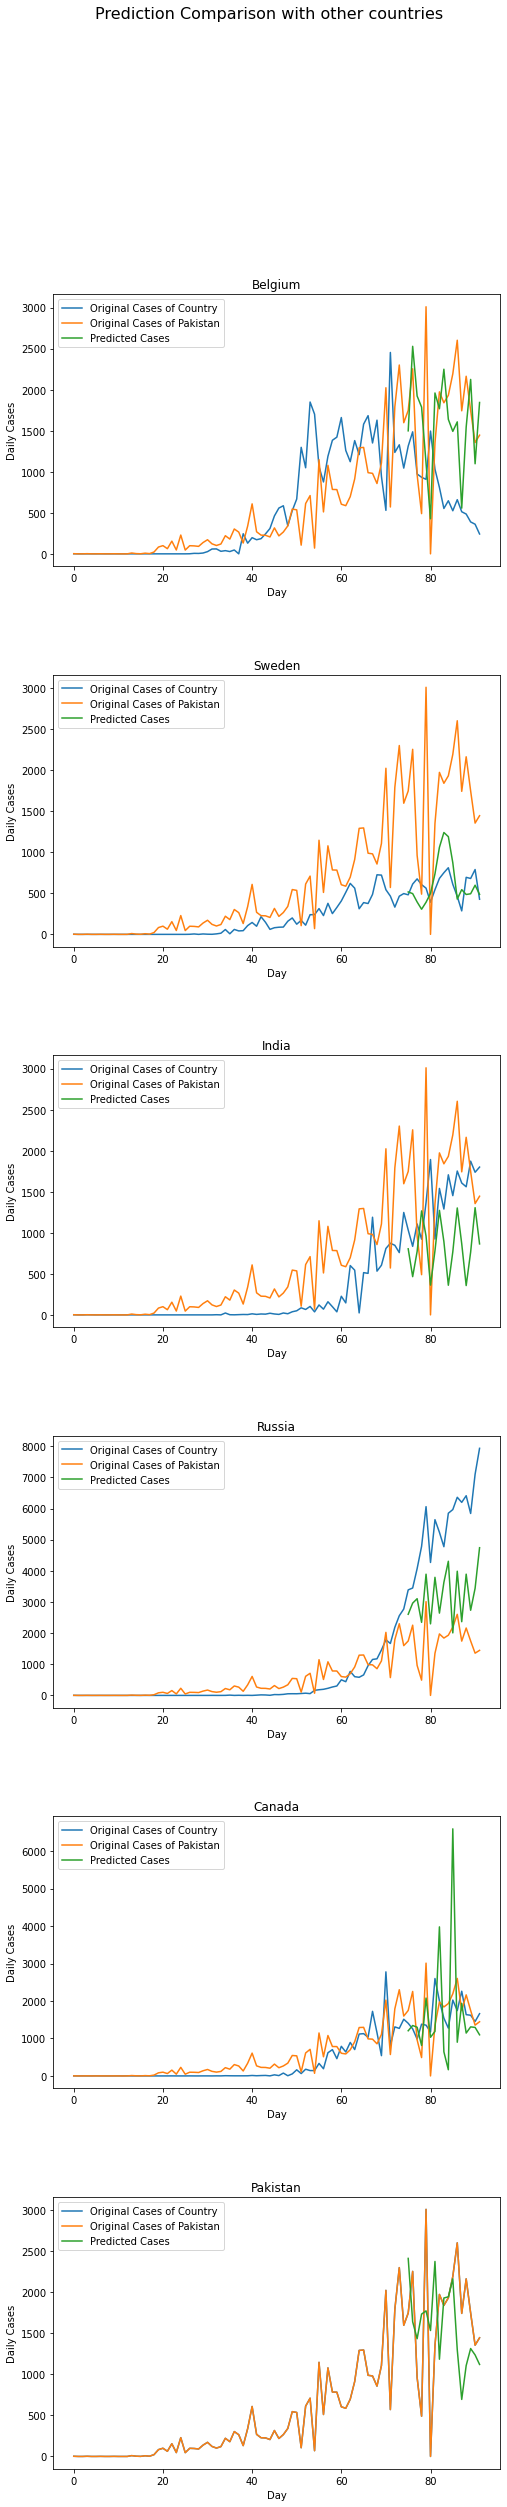

In [650]:
days = [x for x in range(92)]
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
fig,axs = plt.subplots(6,1,figsize=(8,40))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle('Prediction Comparison with other countries', fontsize=16)
i = 0
for country in pred_trend.keys():
    country_series = getDailyCaseSeries(country,dataset,'5/27/20')
    axs[i].plot(days,country_series[:len(days)], label = "Original Cases of Country")
    axs[i].plot(days,pak_series, label = "Original Cases of Pakistan")
    axs[i].plot(days[-17:],pred_trend[country], label = "Predicted Cases")
    axs[i].set_title(country)
    axs[i].legend(loc='upper left')
    i+=1
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Daily Cases')

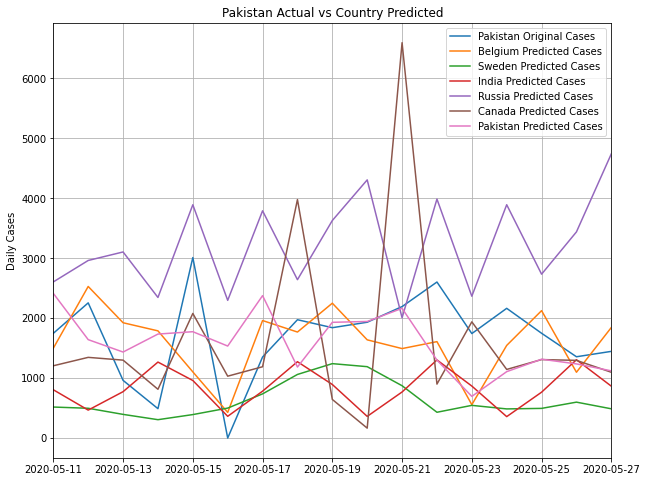

In [645]:
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series[-17:],label = "Pakistan Original Cases")
for country in pred_trend.keys():
  plt.plot(index,pred_trend[country], label = country+" Predicted Cases")
plt.legend();

## Prediction Comparison (27th May to 27th June)

In [651]:
days = [x for x in range(92+31)]
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
fig,axs = plt.subplots(6,1,figsize=(8,40))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle('Prediction Comparison with other countries', fontsize=16)
i = 0
for country in pred_trend.keys():
    country_series = getDailyCaseSeries(country,dataset,'5/27/20')
    axs[i].plot(days[:92],country_series[:92], label = "Original Cases of Country")
    axs[i].plot(days[:92],pak_series, label = "Original Cases of Pakistan")
    axs[i].plot(days[92:],pred_trend_fut[country], label = "Predicted Cases of Future")
    axs[i].set_title(country)
    axs[i].legend(loc='upper left')
    i+=1
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Daily Cases')

In [653]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
# plt.plot(index,pak_series_test,label = "Pakistan Cases")
for country in pred_trend_fut.keys():
  plt.plot(index,pred_trend_fut[country], label = country+" Predicted Cases")
plt.legend(loc='upper right');